# Импорт библиотек

In [1]:
import os
import numpy as np
import pandas as pd
import missingno as msn

pd.options.mode.chained_assignment = None

In [2]:
import seaborn as sns
from matplotlib import style
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sns.set()
style.use('fivethirtyeight')

In [3]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [4]:
# from tensorflow import keras
# from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import StandardScaler

# Загрузка и проверка датасета

In [5]:
data = pd.read_csv('heart.csv')

In [6]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [7]:
data.shape

(918, 12)

In [8]:
data.nunique().to_frame().rename(columns={0: 'parameters'})

,parameters
Age,50
Sex,2
ChestPainType,4
RestingBP,67
Cholesterol,222
FastingBS,2
RestingECG,3
MaxHR,119
ExerciseAngina,2
Oldpeak,53


In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


# Пропущенные значения

Text(0.5, 1.11, 'Missing value in the dataset')

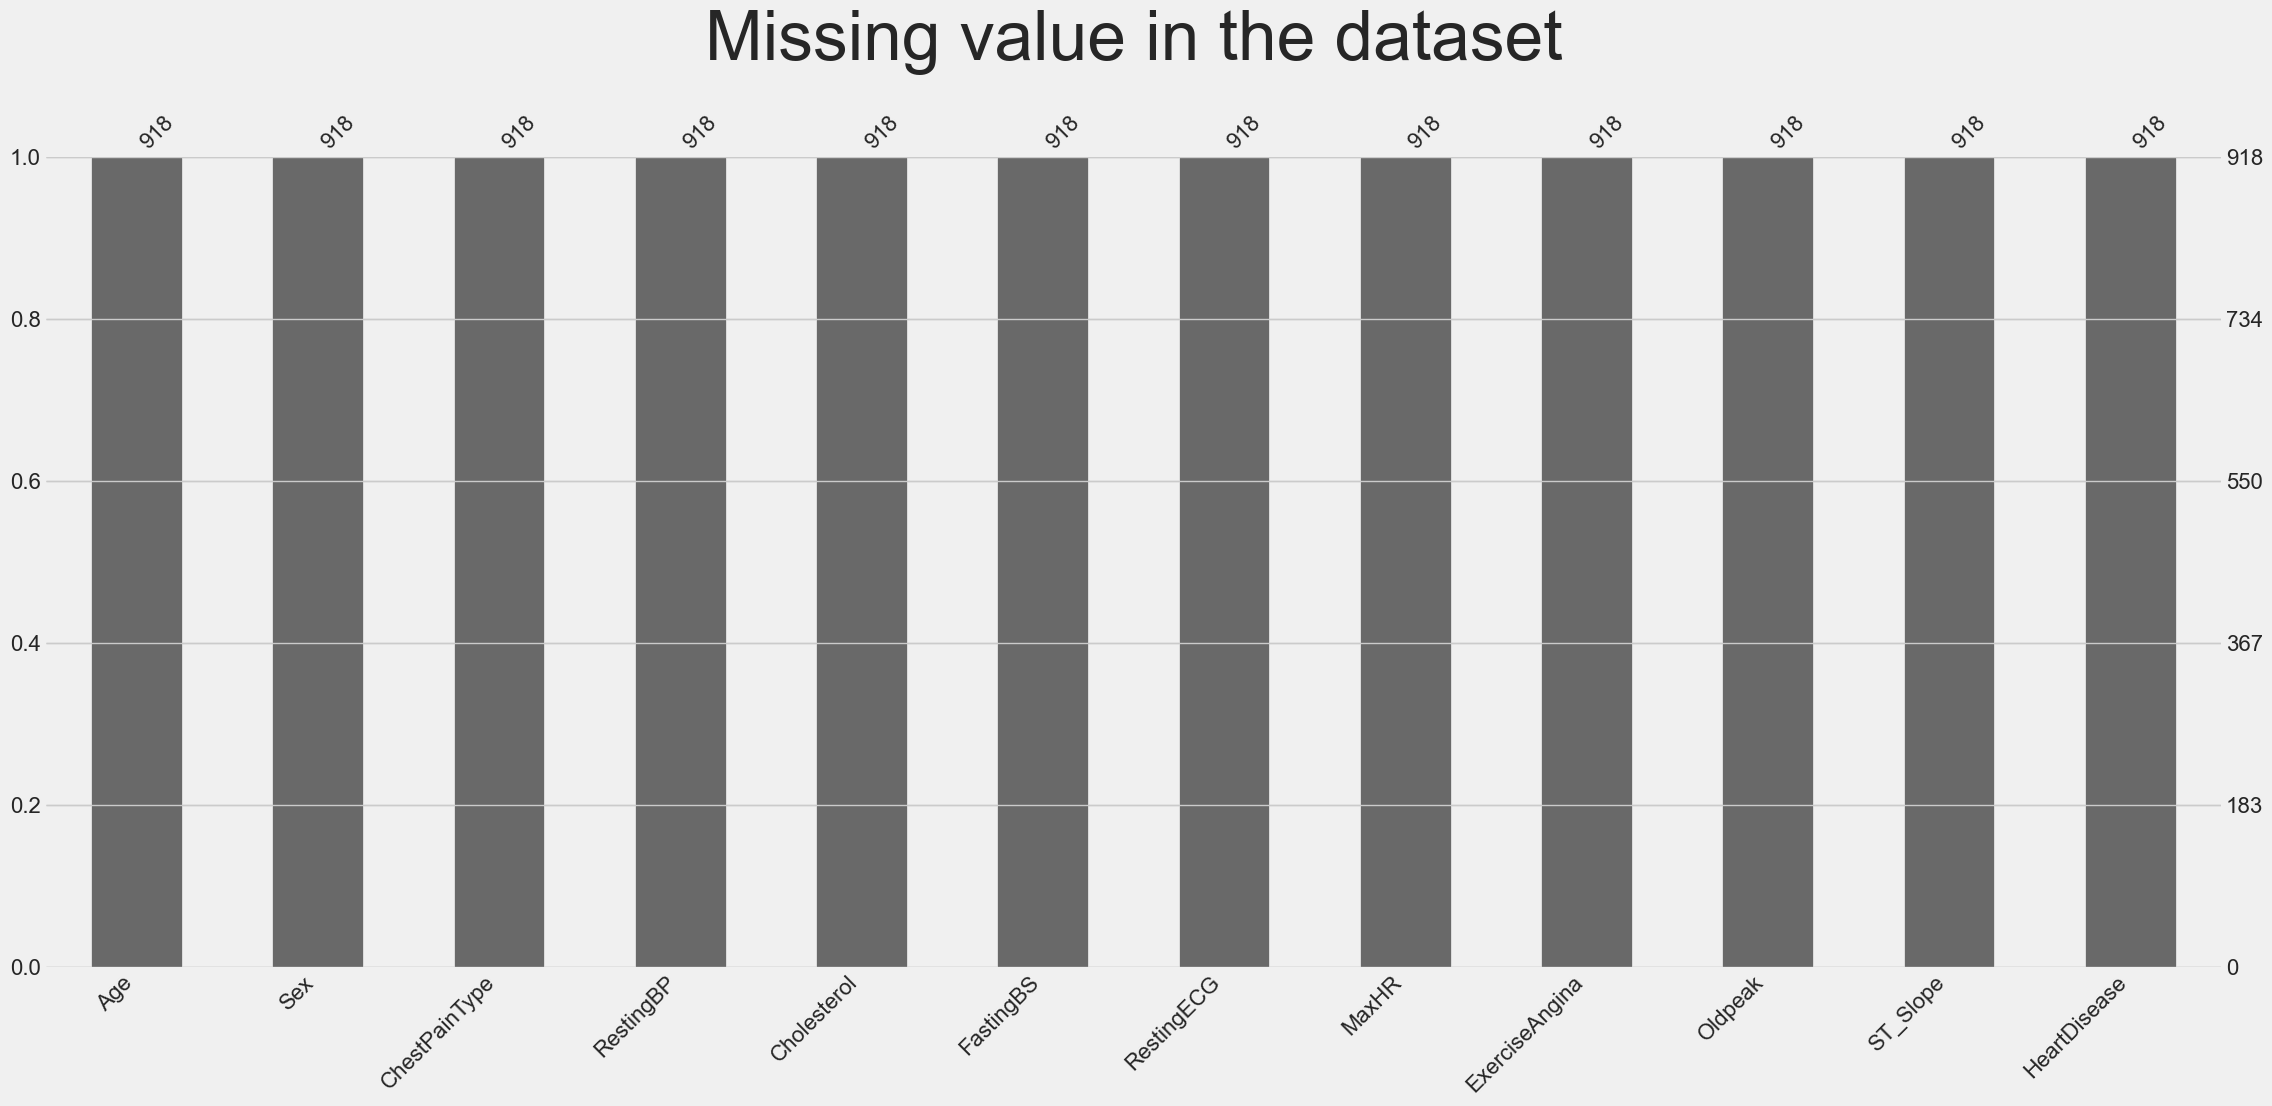

In [10]:
msn.bar(data).set_title('Missing value in the dataset', size=50, y=1.11)

# Распределение классов таргета

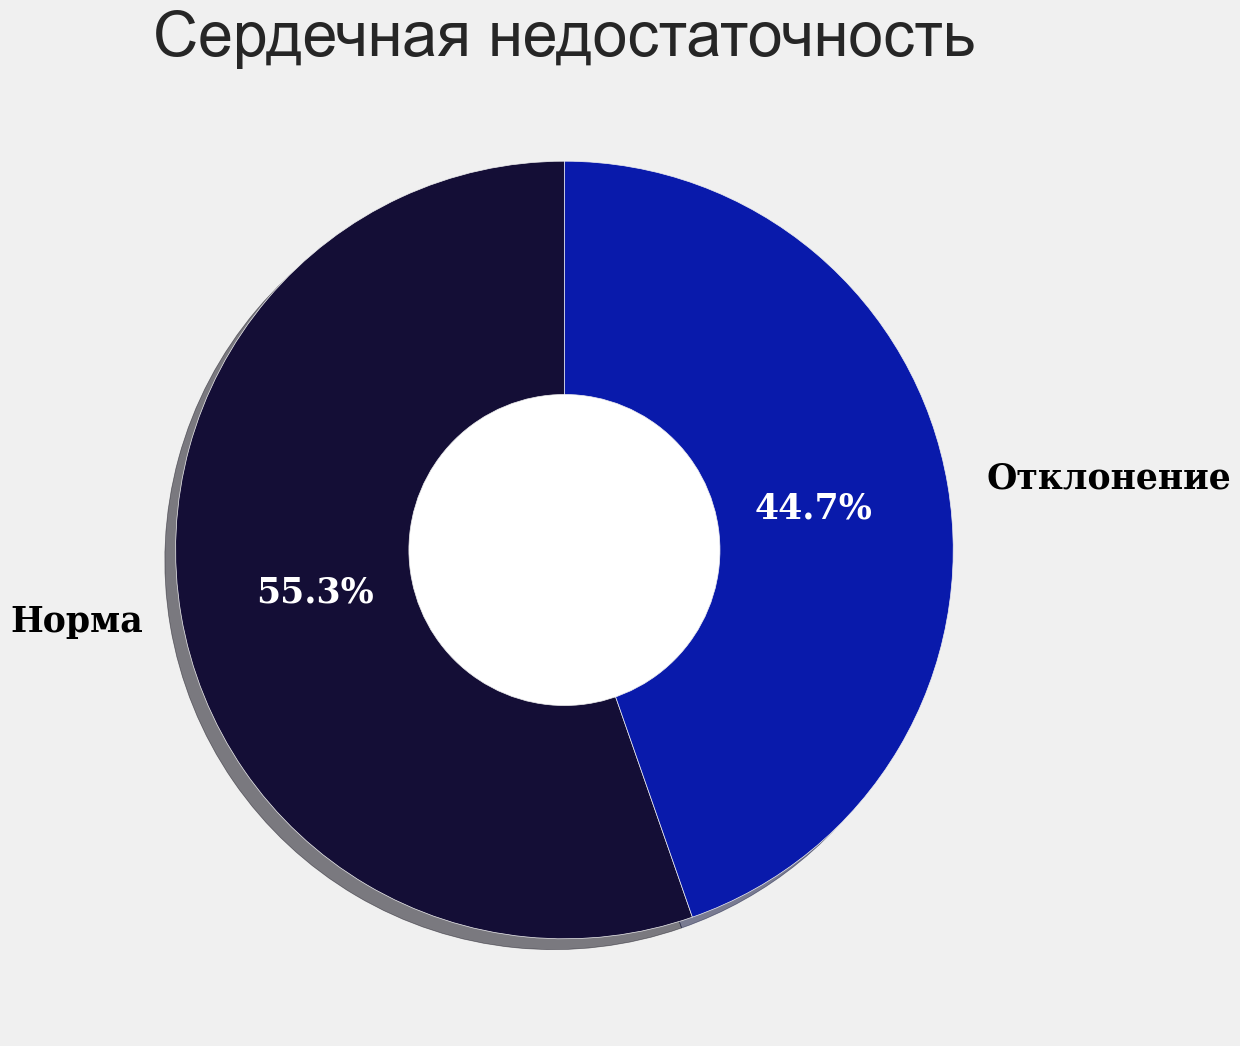

In [11]:
pie_colors = ('#140E36', '#091AAB')

pred_classes = data.HeartDisease.value_counts()

plt.figure(figsize=(17, 12))
patches, texts, pcts = plt.pie(pred_classes,
        labels=['Норма', 'Отклонение'],
        colors=pie_colors,
        pctdistance=0.65,
        shadow=True,
        startangle=90,
        autopct='%1.1f%%',
        textprops={'fontsize': 25,
                   'color': 'black',
                   'weight': 'bold',
                   'family': 'serif'})
plt.setp(pcts, color='white')
plt.title('Сердечная недостаточность', size=45)

centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Анализ признаков

In [18]:
colors = ['lightcoral','deepskyblue',
          'orchid',    'tomato',
          'teal',      'darkcyan',
          'limegreen', 'darkorange']

def distribution_plot(column, title):

    fig = plt.figure(figsize=(17, 7))
    grid = GridSpec(nrows=2, ncols=1, figure=fig)
    color = np.random.choice(colors, 1)[0]

    ax0 = fig.add_subplot(grid[0, :])
    ax0.set_title(f'Гистограмма и бокс-плот для {title}', y=1.05)
    sns.histplot(column, ax=ax0, color=color)
    
    print(f'Skewness of {title} =======>>> {np.round(column.skew(), 3)}')

    ax1 = fig.add_subplot(grid[1, :])
    plt.axis('off')
    sns.boxplot(x=column, ax=ax1, color=color)

### Возраст

Skewness of Age =======>>> -0.196


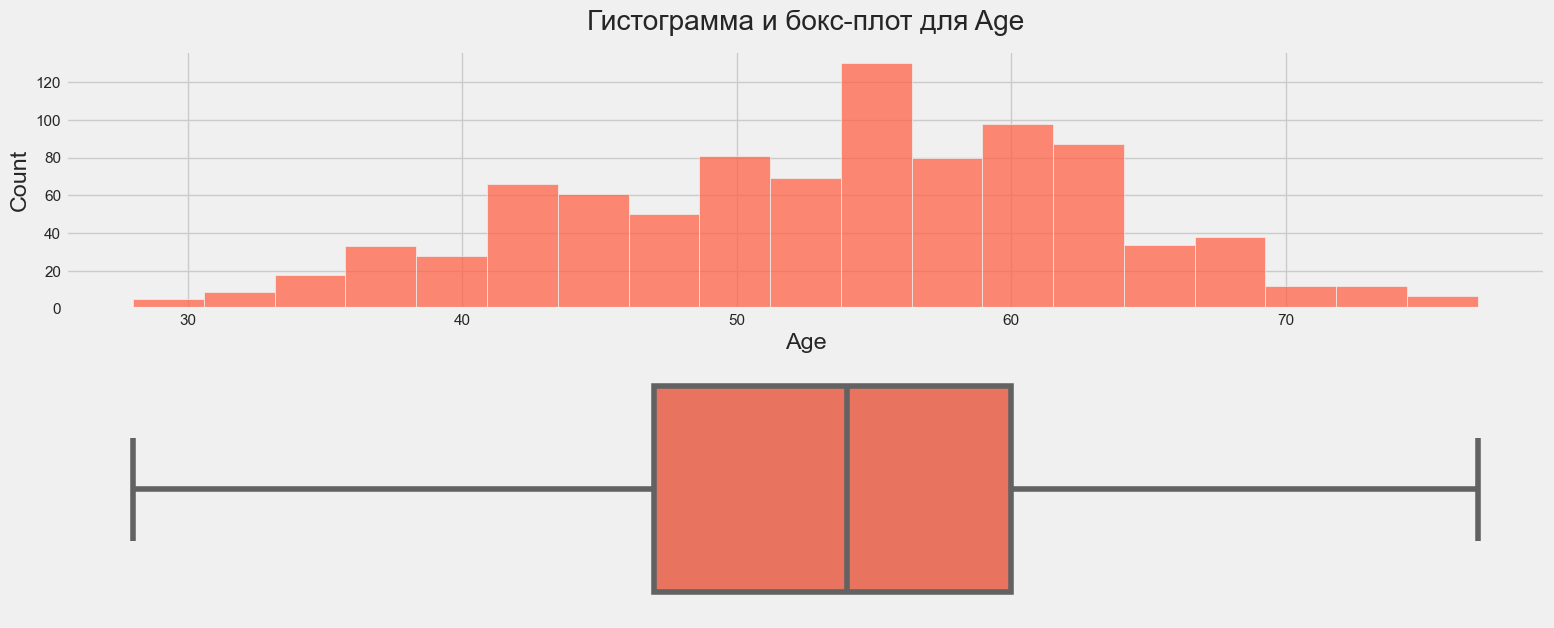

In [19]:
distribution_plot(data.Age, 'Age')

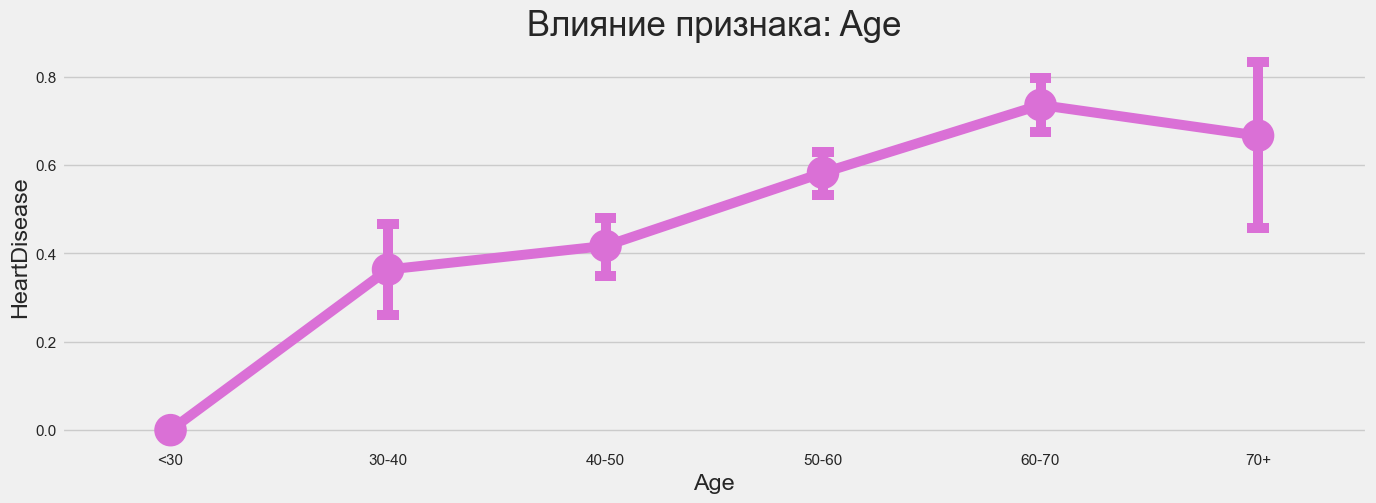

In [20]:
def age_plot(data, col_name):

    age_data = data[[col_name, 'HeartDisease']]
    age_data[col_name] = pd.cut(age_data[col_name],
                               bins=[0, 30, 40, 50, 60, 70, 100],
                               labels=['<30',
                                       '30-40',
                                       '40-50',
                                       '50-60',
                                       '60-70',
                                       '70+'])

    color = np.random.choice(colors, 1)[0]
    plt.figure(figsize=(15, 5))
    sns.pointplot(x=col_name, y='HeartDisease',
                  dodge=0.1, capsize=.1, data=age_data, color=color) \
                 .set_title(f'Влияние признака: {col_name}', fontsize=25)


age_plot(data, 'Age')

### Вывод о возрасте:
#### Существует тенденция, о которой можно судить, что с возрастом увеличивается вероятность сердечной недостаточности

### Пол

[Text(0, 0, 'M'), Text(1, 0, 'F')]

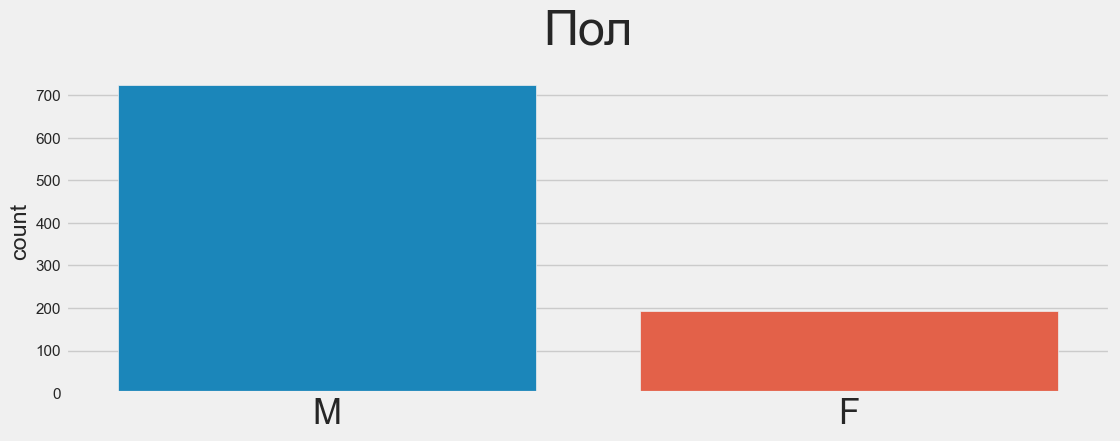

In [21]:
plt.figure(figsize=(12, 4))
gender_plot = sns.countplot(x=data.Sex)
gender_plot.set_title('Пол', fontsize=35, y=1.05)
gender_plot.set(xlabel=None)
gender_plot.set_xticklabels(gender_plot.get_xticklabels(), size=25)

### Виды боли в груди:
- TA  -> Типичная ангина
- ATA -> Атипичная стенокардия
- NAP -> Боль, не вызывнная ангиной
- ASY -> Асимптоматика

<AxesSubplot:xlabel='ChestPainType', ylabel='HeartDisease'>

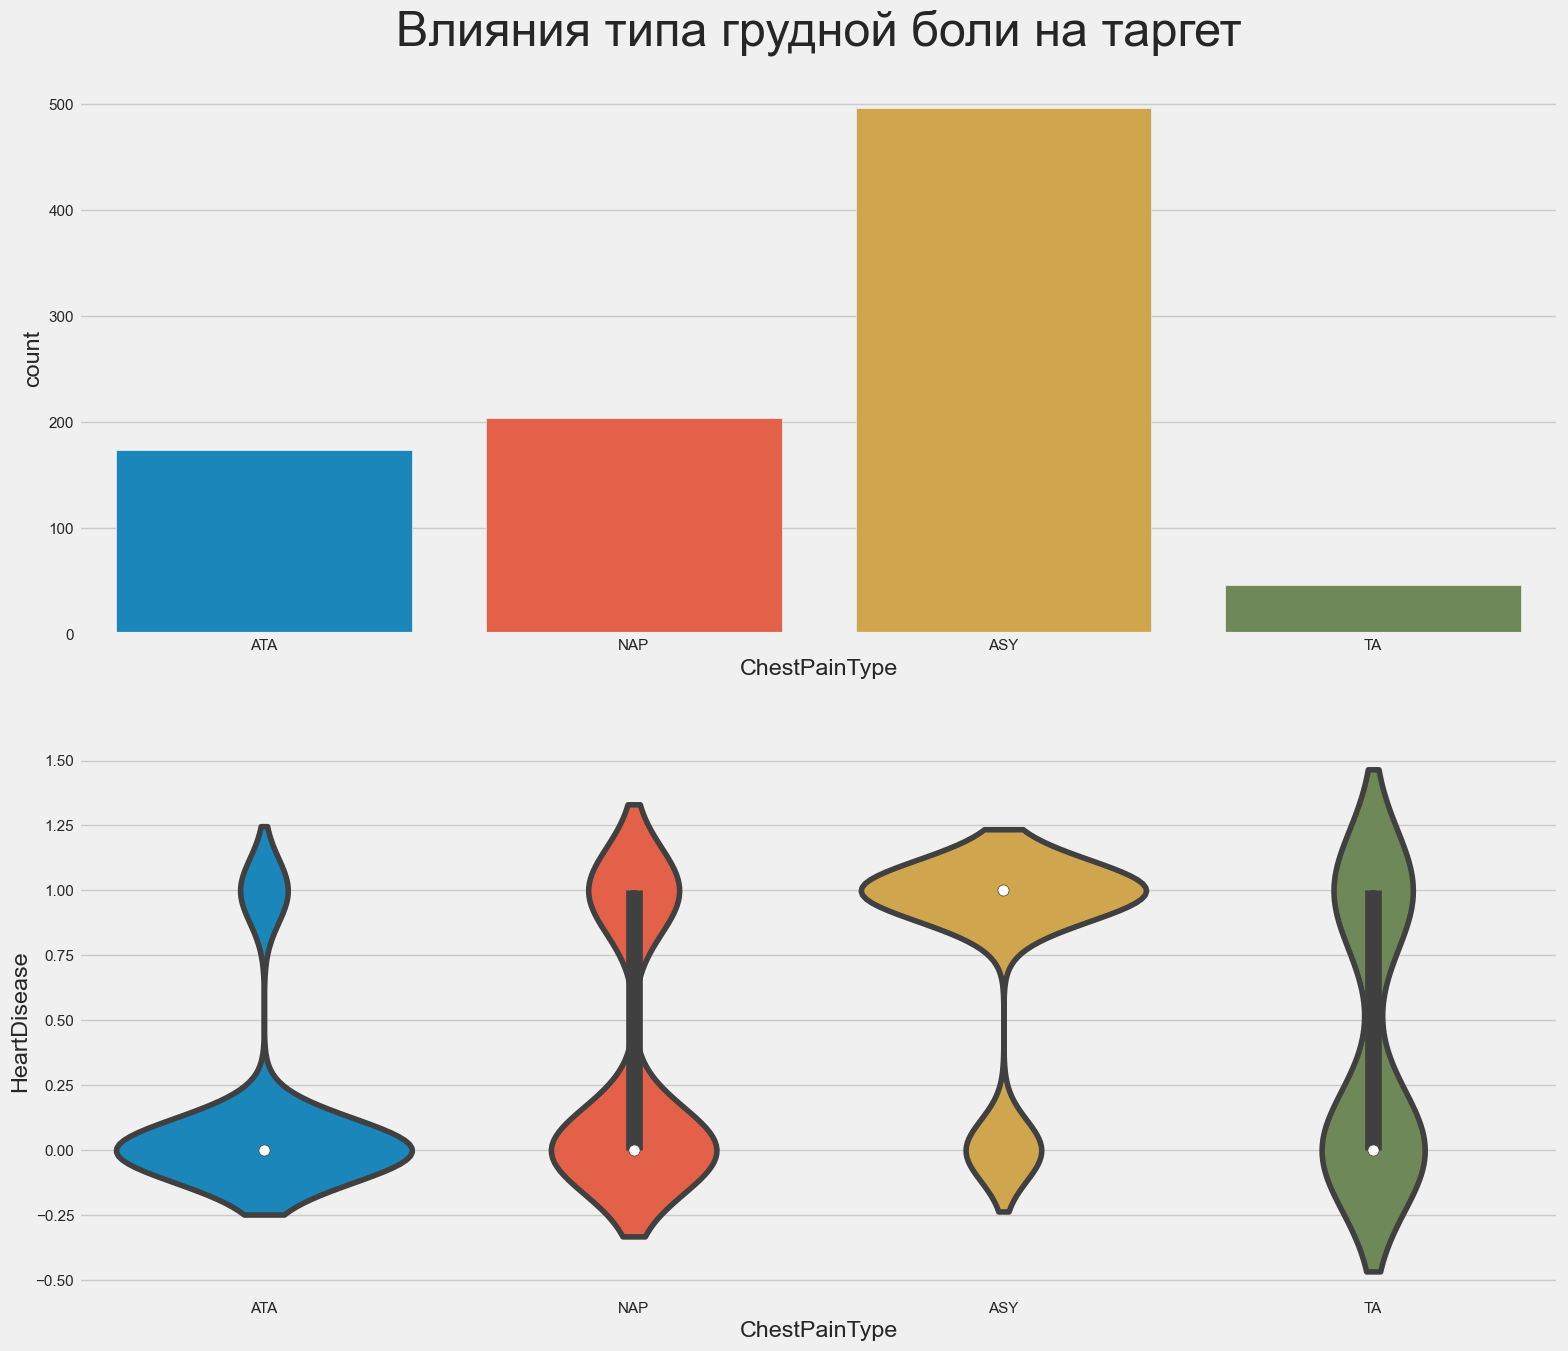

In [22]:
fig = plt.figure(figsize=(17, 15))
grid = GridSpec(ncols=1, nrows=2, figure=fig)

ax1 = fig.add_subplot(grid[0, :])
pain_type_plot = sns.countplot(x=data.ChestPainType, ax=ax1)
pain_type_plot.set_title('Влияния типа грудной боли на таргет',
                         fontsize=35, y=1.05)

ax2 = fig.add_subplot(grid[1, :])
sns.violinplot(x=data.ChestPainType, y='HeartDisease', data=data, ax=ax2)

#### Вывод:
Бессимптомность в большинстве случаев сильнее влияет на
прогрессирование болезни, в то время как пациенты с
Атипичная стенокардия имеет меньше (в среднем) случаев

### Кровяное давление в состоянии покоя [mm Hg]

Skewness of Resting blood pressure =======>>> 0.18


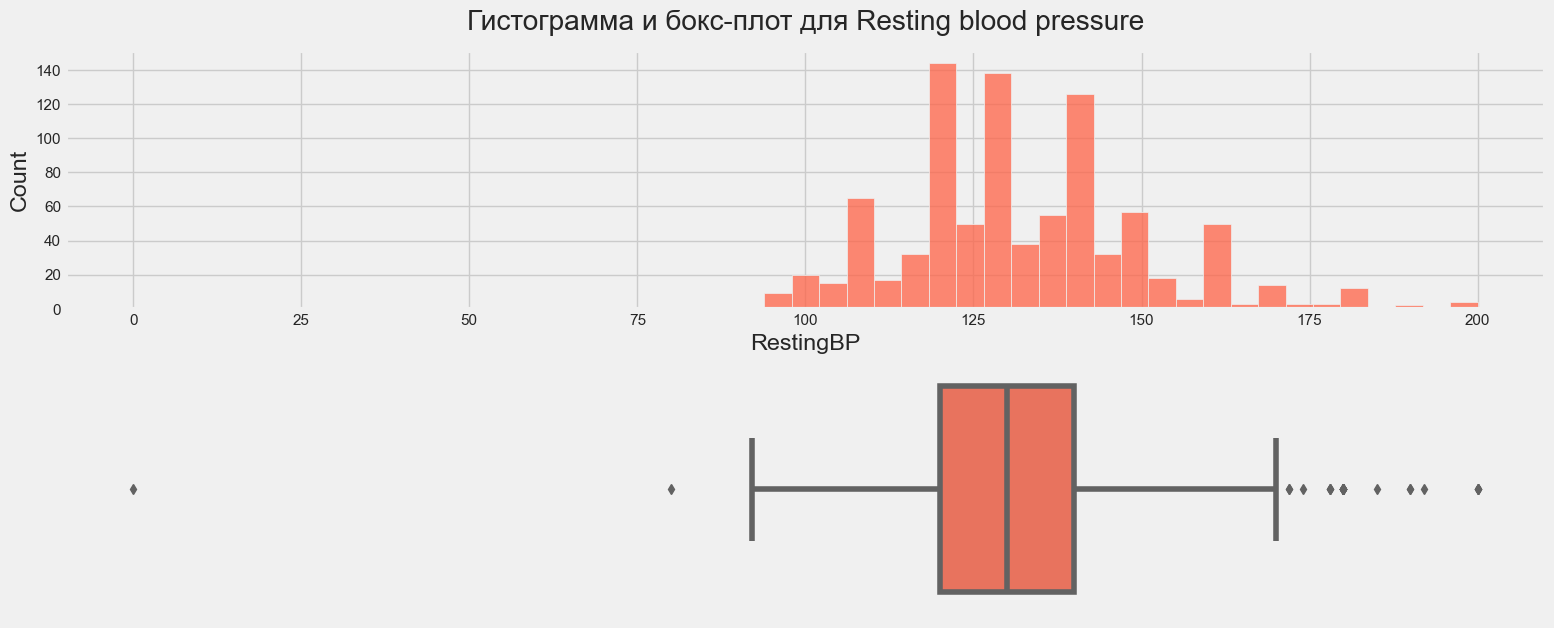

In [23]:
distribution_plot(data.RestingBP, 'Resting blood pressure')

In [24]:
minimal_pressure = data[data.RestingBP < 50]
minimal_pressure

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


#### Стоит удалить выбросы

In [25]:
data = data[data.RestingBP > 50]

Skewness of Resting blood pressure =======>>> 0.607


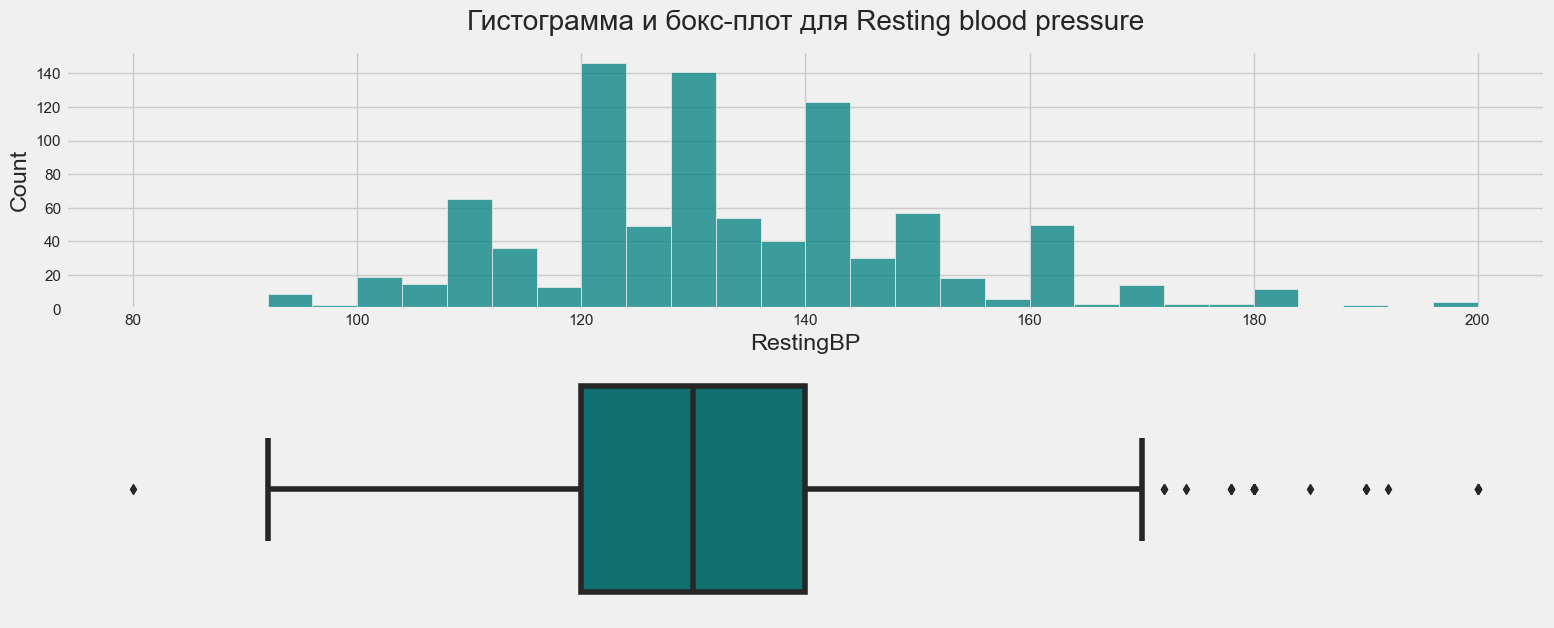

In [26]:

distribution_plot(data.RestingBP, 'Resting blood pressure')

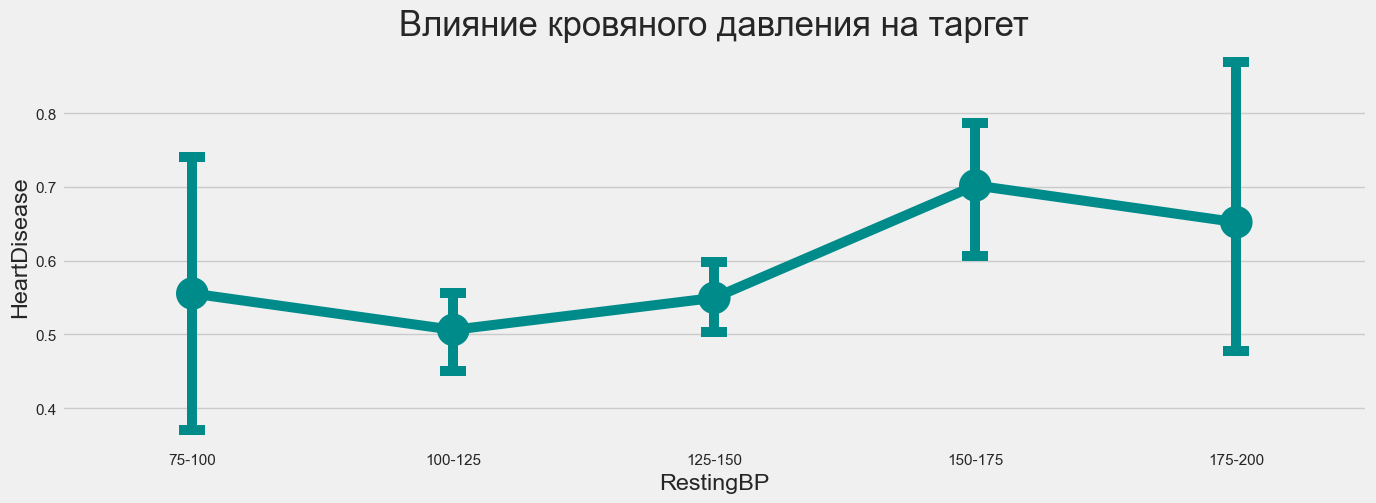

In [27]:
def pressure_plot(data, col_name):

    pressure_data = data[[col_name, 'HeartDisease']]
    pressure_data[col_name] = pd.cut(pressure_data[col_name],
                               bins=[75, 100, 125, 150, 175, 200],
                               labels=['75-100',
                                       '100-125',
                                       '125-150',
                                       '150-175',
                                       '175-200'])

    color = np.random.choice(colors, 1)[0]
    plt.figure(figsize=(15, 5))
    sns.pointplot(x=col_name, y='HeartDisease',
                  dodge=0.1, capsize=.1, data=pressure_data, color=color) \
                 .set_title(f'Влияние кровяного давления на таргет', fontsize=25)


pressure_plot(data, 'RestingBP')

### Холестерин в крови [mm/dl]

Skewness of Cholesterol =======>>> -0.612


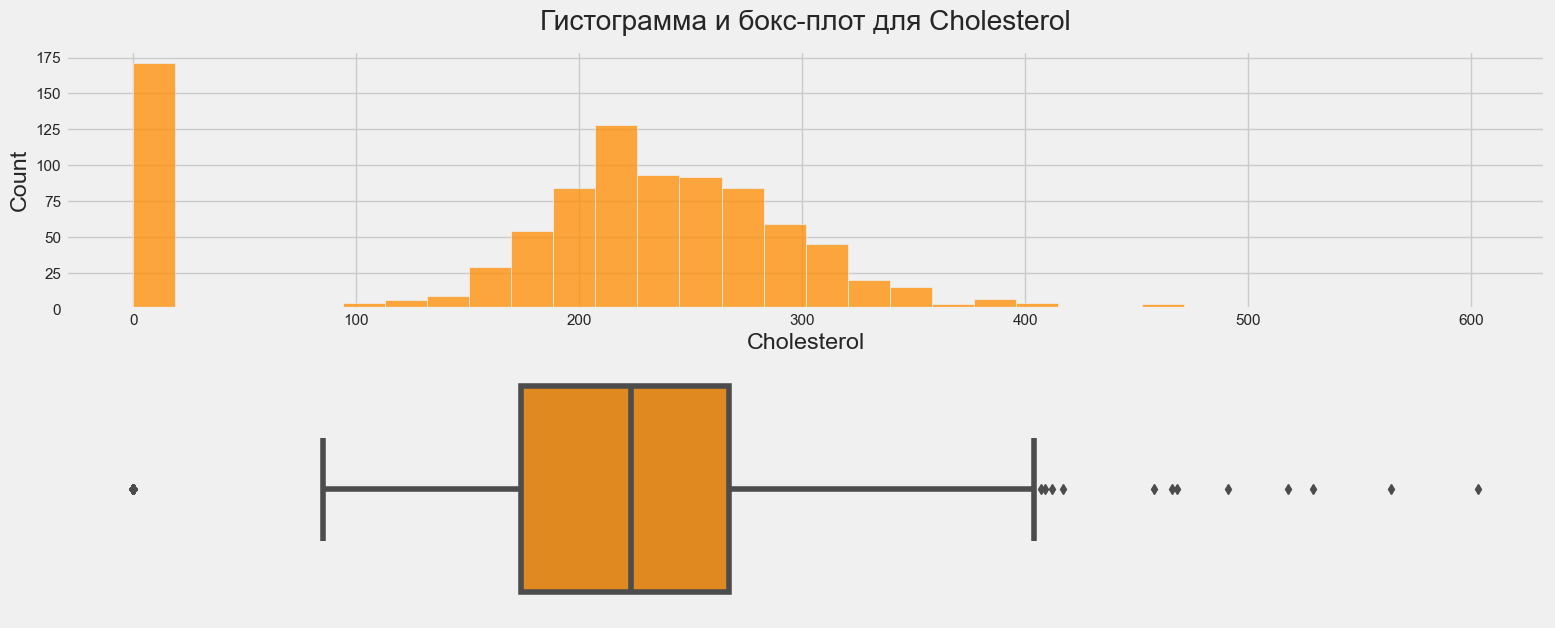

In [28]:
distribution_plot(data.Cholesterol, 'Cholesterol')

In [ ]:
data = data[data.Cholesterol != 0]

Skewness of Cholesterol =======>>> -0.612


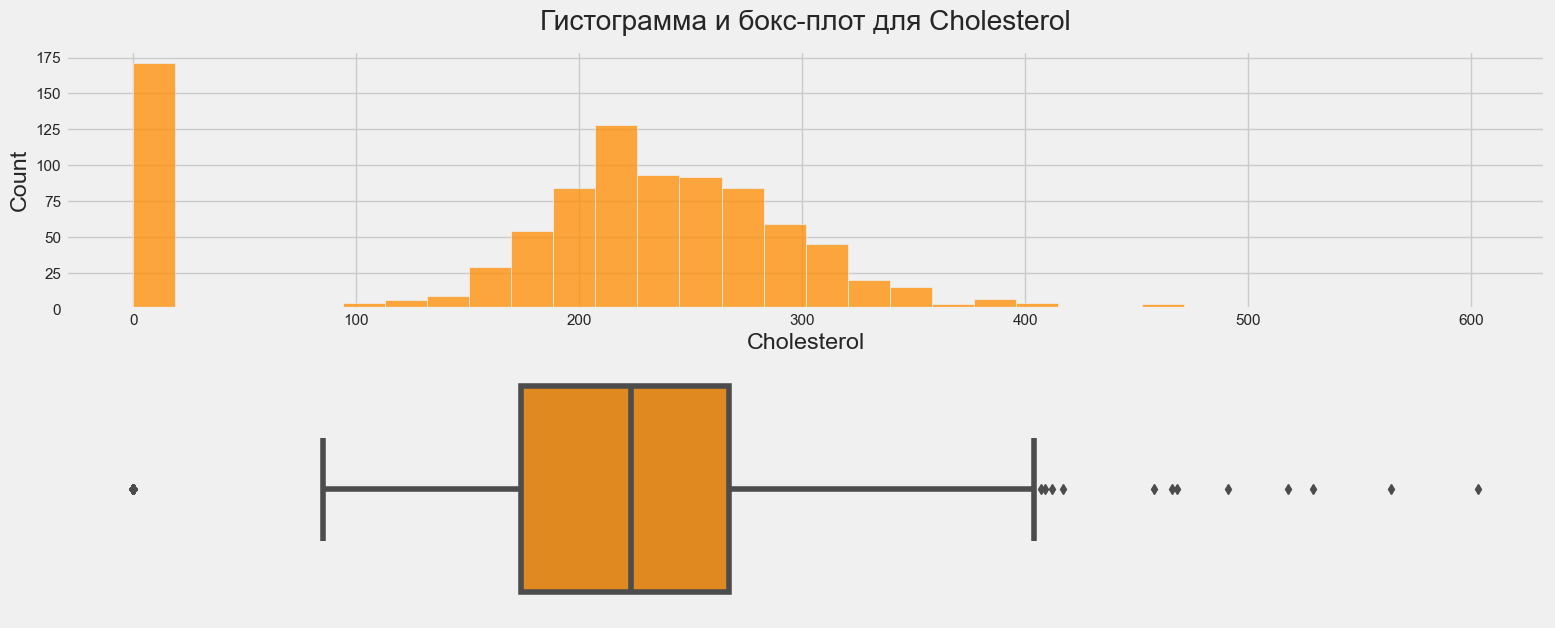

In [29]:
distribution_plot(data.Cholesterol, 'Cholesterol')

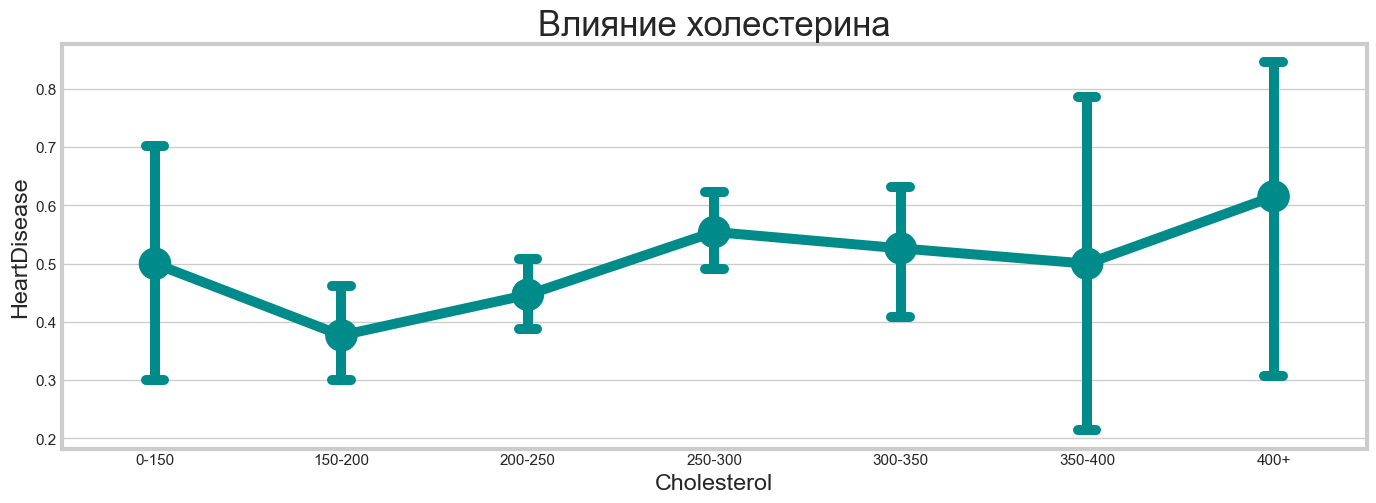

In [30]:
def cholesterol_plot(data, col_name):

    cholesterol_data = data[[col_name, 'HeartDisease']]
    cholesterol_data[col_name] = pd.cut(cholesterol_data[col_name],
                               bins=[0, 150, 200, 250, 300, 350, 400, 1000],
                               labels=['0-150',
                                       '150-200',
                                       '200-250',
                                       '250-300',
                                       '300-350',
                                       '350-400',
                                       '400+'])

    color = np.random.choice(colors, 1)[0]
    plt.figure(figsize=(15, 5))
    sns.pointplot(x=col_name, y='HeartDisease',
                  dodge=0.1, capsize=.1, data=cholesterol_data, color=color) \
                 .set_title(f'Влияние холестерина', fontsize=25)


cholesterol_plot(data, 'Cholesterol')

### Сахар в крови натощак
- 1 -> Значени > 120 мг/дл
- 0 -> Ниже порога

[Text(0, 0, '>120'), Text(1, 0, 'other')]

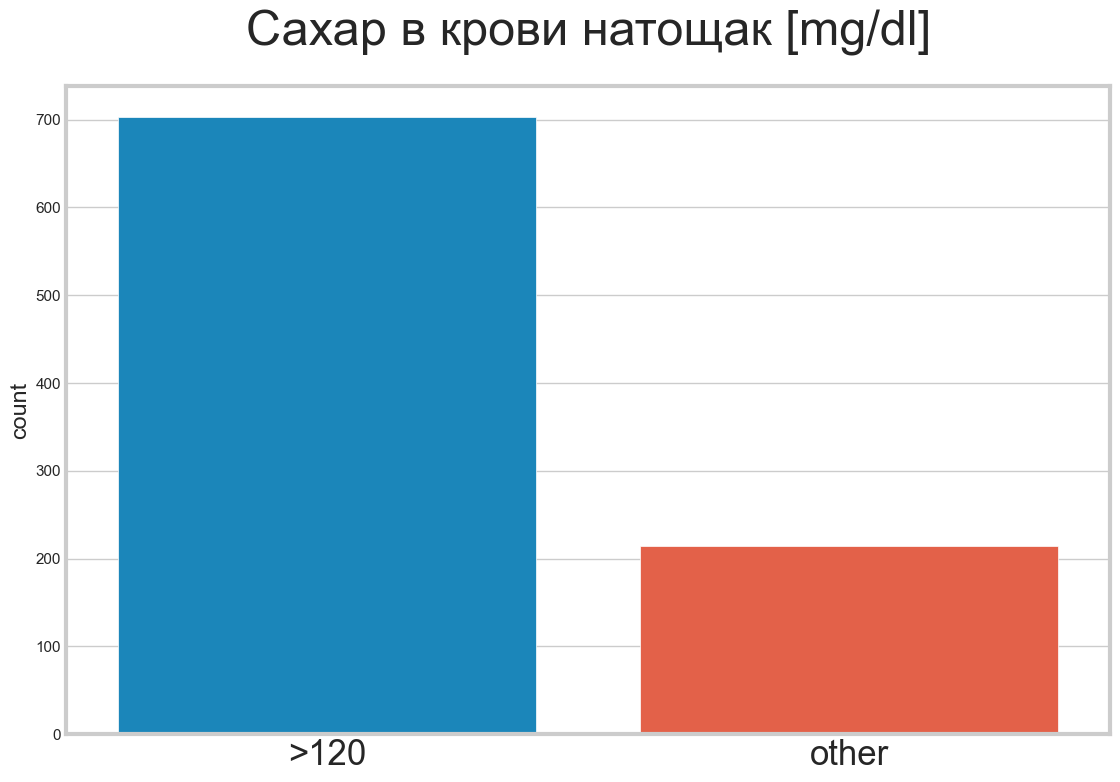

In [32]:
plt.figure(figsize=(12, 8))
active_plot = sns.countplot(x=data.FastingBS)
active_plot.set_title('Сахар в крови натощак [mg/dl]', fontsize=35, y=1.05)
active_plot.set(xlabel=None)
active_plot.set_xticklabels(['>120', 'other'], size=25)

Text(0.5, 1.05, 'Влияния сахара в крови натощак')

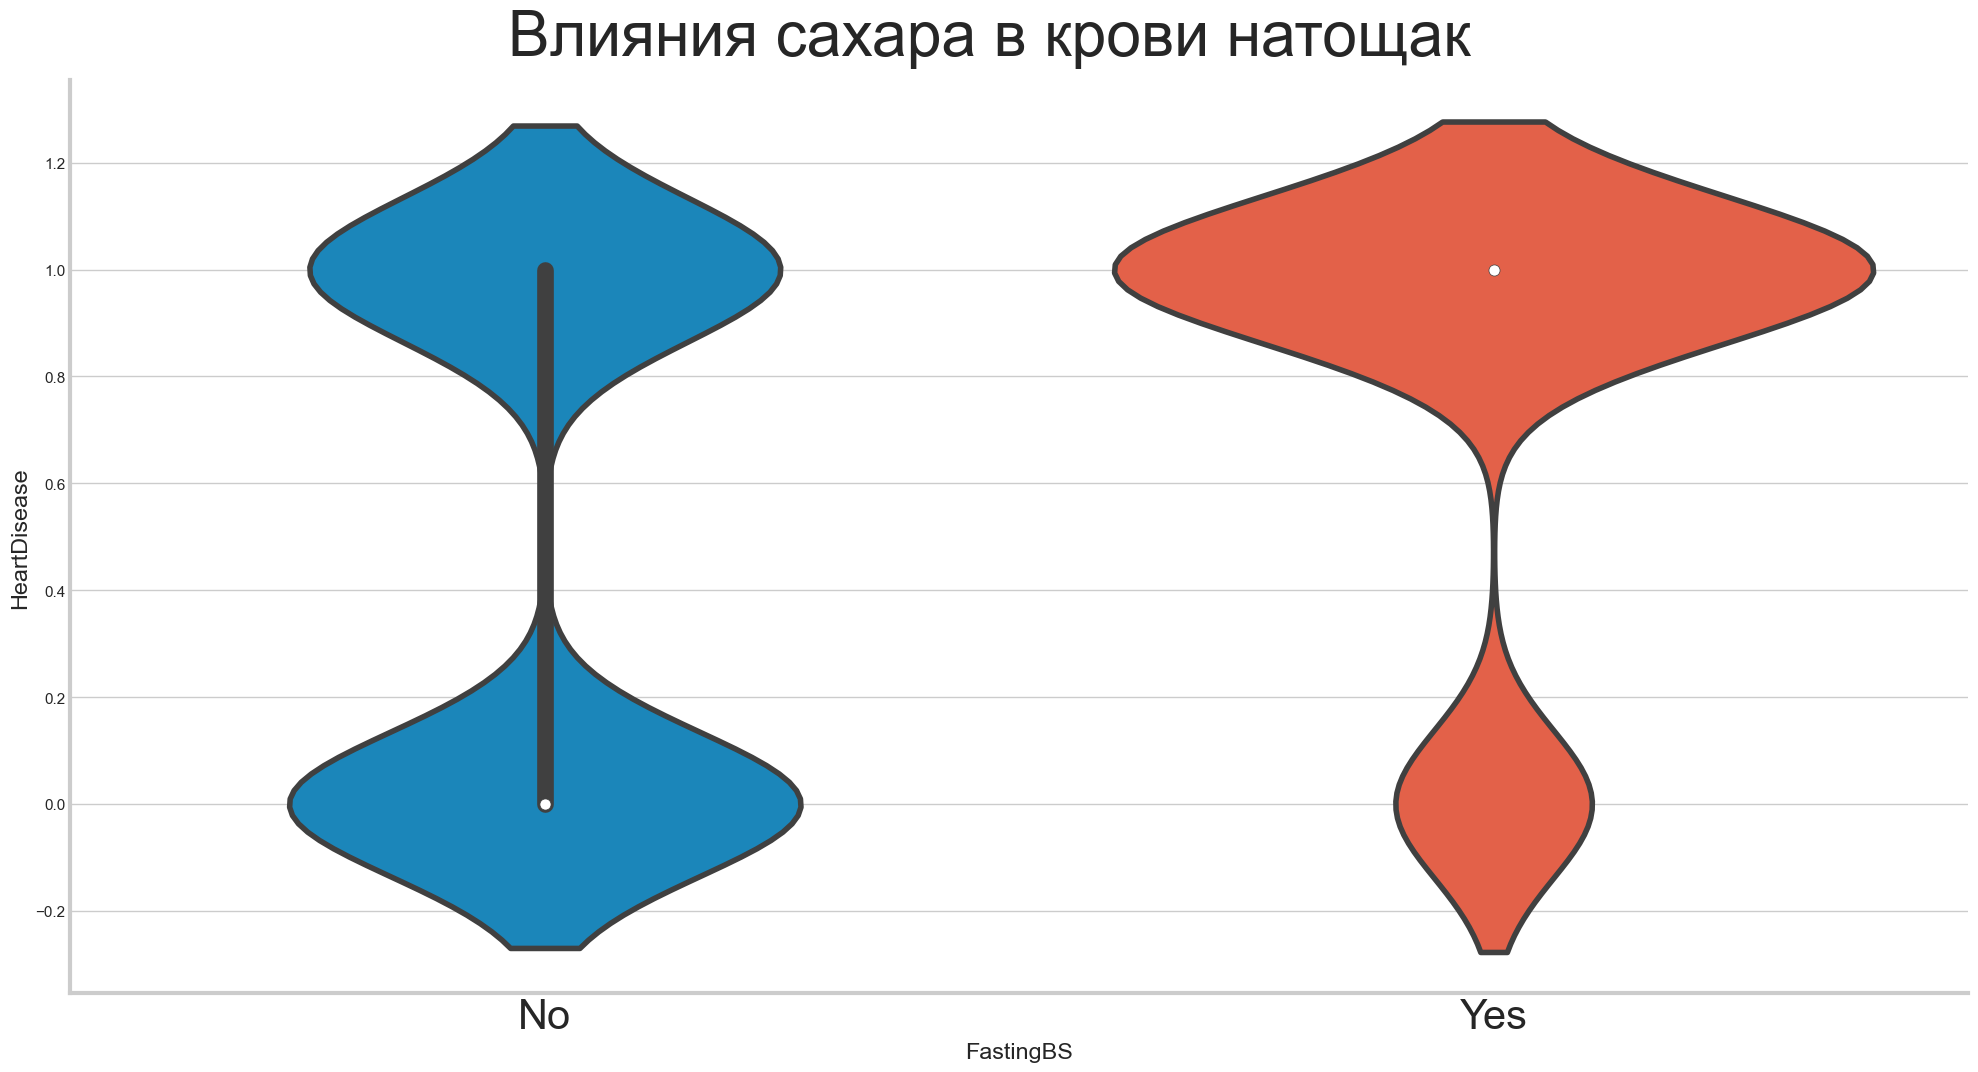

In [33]:
sugar_plot = sns.catplot(x='FastingBS', y='HeartDisease', data=data, height=10, aspect=2, kind='violin')
sugar_plot.set_xticklabels(['No', 'Yes'], size=30)
sugar_plot.fig.suptitle('Влияния сахара в крови натощак', size=45, y=1.05)

### Результаты электрокардиограммы в состоянии покоя
- Номальное
- ST     -> с патологией ST-T волн
- LVH    -> показывая вероятную или определенную гипертрофию левого желудочка по критериям Эстеса

[None, None, None, None, None, None]

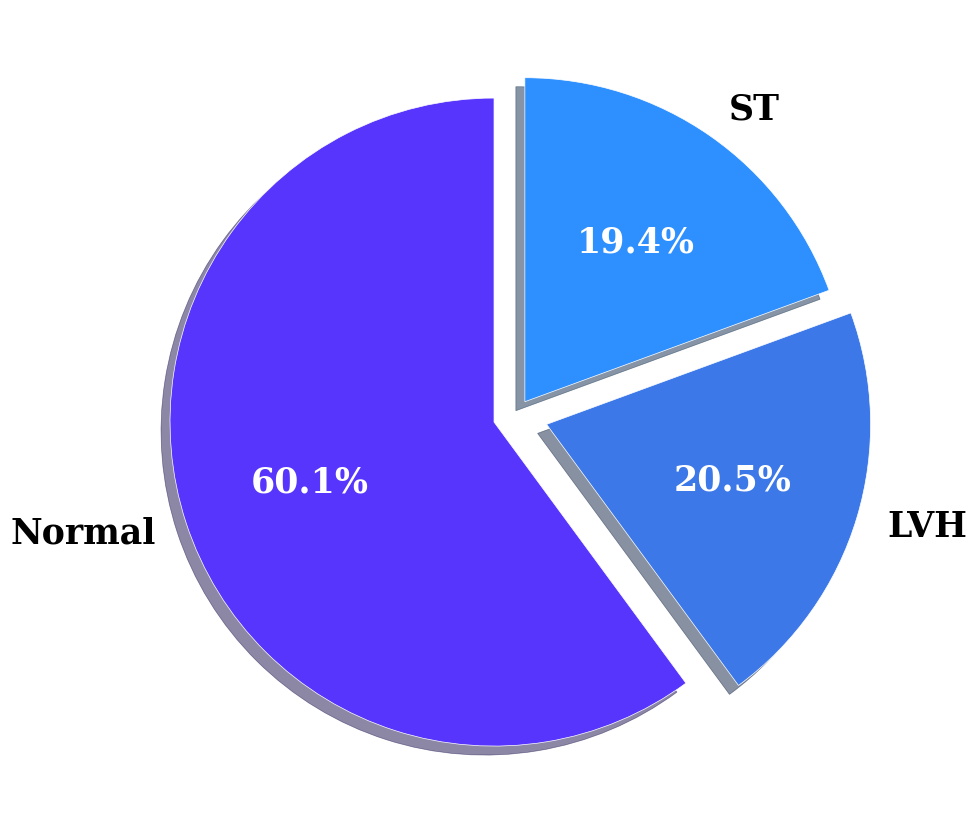

In [34]:
cardiogram_data = data.RestingECG.value_counts()

explode = (0.07, 0.1, 0.05)
pie_colors = ('#5735FD', '#3C78E8', '#2E90FF')

plt.figure(figsize=(15, 10))
patches, texts, pcts = plt.pie(cardiogram_data,
        labels=cardiogram_data.index,
        explode=explode,
        colors=pie_colors,
        shadow=True,
        startangle=90,
        autopct='%1.1f%%',
        textprops={'fontsize': 25,
                   'color': 'black',
                   'weight': 'bold',
                   'family': 'serif'})
plt.setp(pcts, color='white')

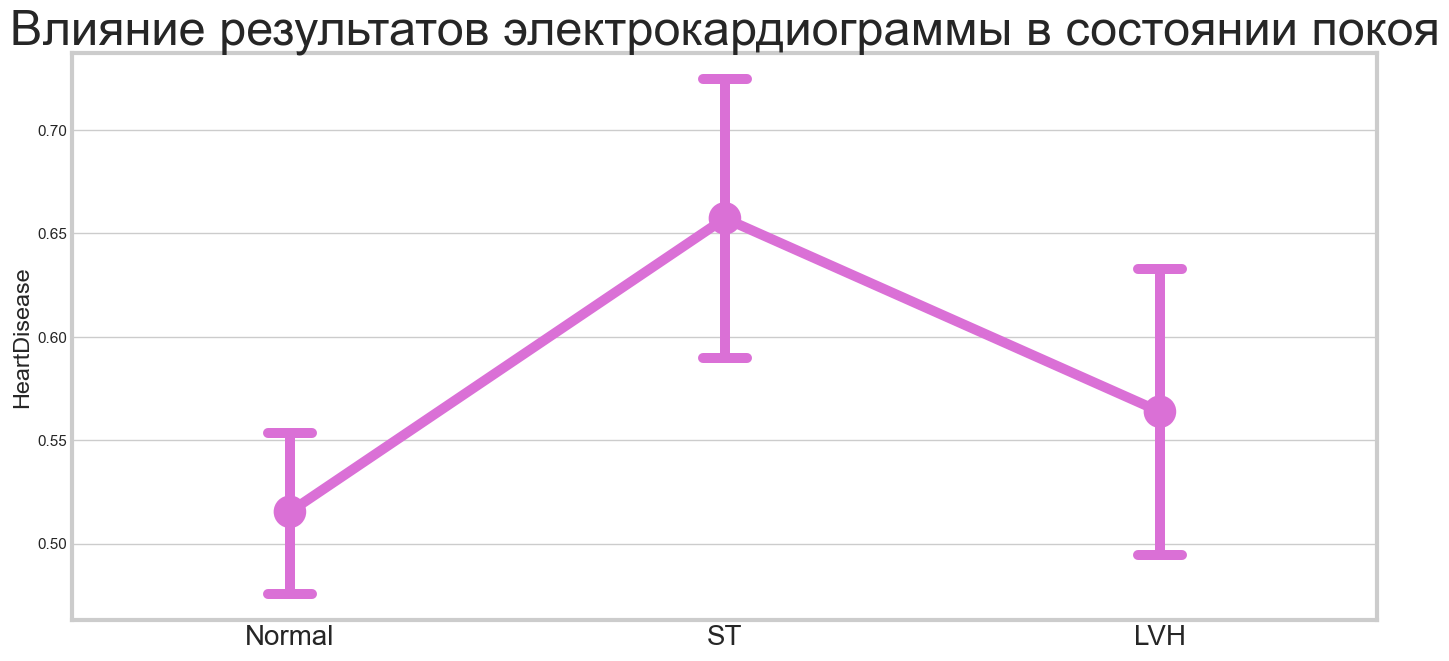

In [35]:
def cardio_plot(data, col_name):

    cardio_data = data[[col_name, 'HeartDisease']]

    color = np.random.choice(colors, 1)[0]
    plt.figure(figsize=(15, 7))
    cardio = sns.pointplot(x=col_name, y='HeartDisease',
                           dodge=0.1, capsize=.1,
                           data=cardio_data,
                           color=color)
    cardio.set_title('Влияние результатов электрокардиограммы в состоянии покоя',
                            fontsize=35)
    cardio.set(xlabel=None)
    cardio.set_xticklabels(cardio.get_xticklabels(), size=20)


cardio_plot(data, 'RestingECG')

### Максимальный сердечный ритм

Skewness of Maximum heart rate =======>>> -0.142


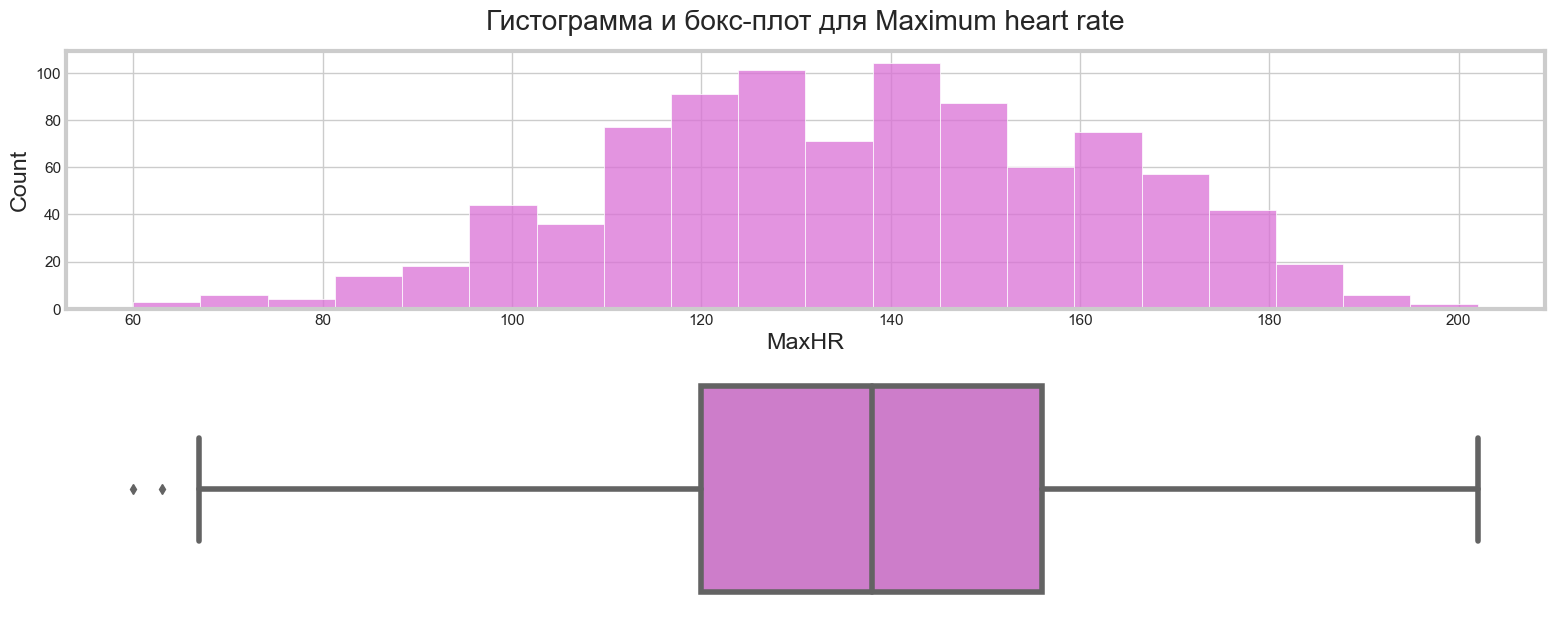

In [36]:
distribution_plot(data.MaxHR, 'Maximum heart rate')

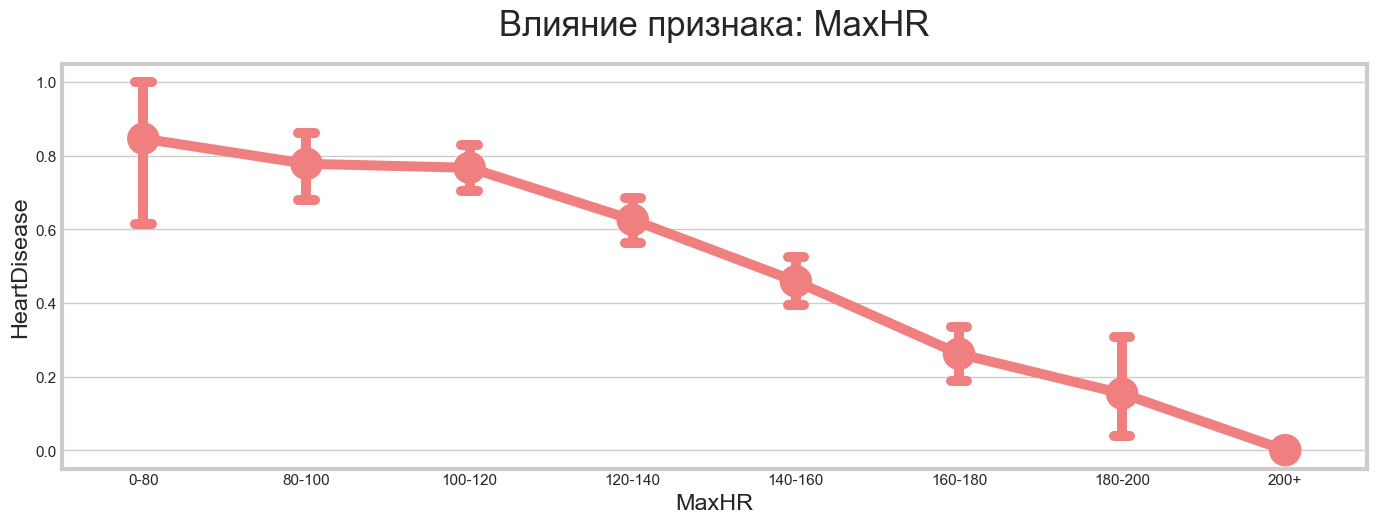

In [37]:

def max_hr_plot(data, col_name):

    max_hr_data = data[[col_name, 'HeartDisease']]
    max_hr_data[col_name] = pd.cut(max_hr_data[col_name],
                               bins=[0, 80, 100, 120, 140, 160, 180, 200,
                                     1000],
                               labels=['0-80',
                                       '80-100',
                                       '100-120',
                                       '120-140',
                                       '140-160',
                                       '160-180',
                                       '180-200',
                                       '200+'])

    color = np.random.choice(colors, 1)[0]
    plt.figure(figsize=(15, 5))
    sns.pointplot(x=col_name, y='HeartDisease',
                  dodge=0.1, capsize=.1, data=max_hr_data, color=color) \
                 .set_title(f'Влияние признака: {col_name}', fontsize=25, y=1.05)


max_hr_plot(data, 'MaxHR')

#### Пояснение:
Можно оценить  максимальный пульс в зависимости возраста.
Чтобы оценить максимальную возрастную частоту сердцебиения, необходимо вычесть возраст от 220.

Поэтому можно сделать вывод о том, что связь
обратно по отношению к возрасту пациента


### Стенокардия при двигатлельной активности

[Text(0, 0, 'Нет'), Text(1, 0, 'Есть')]

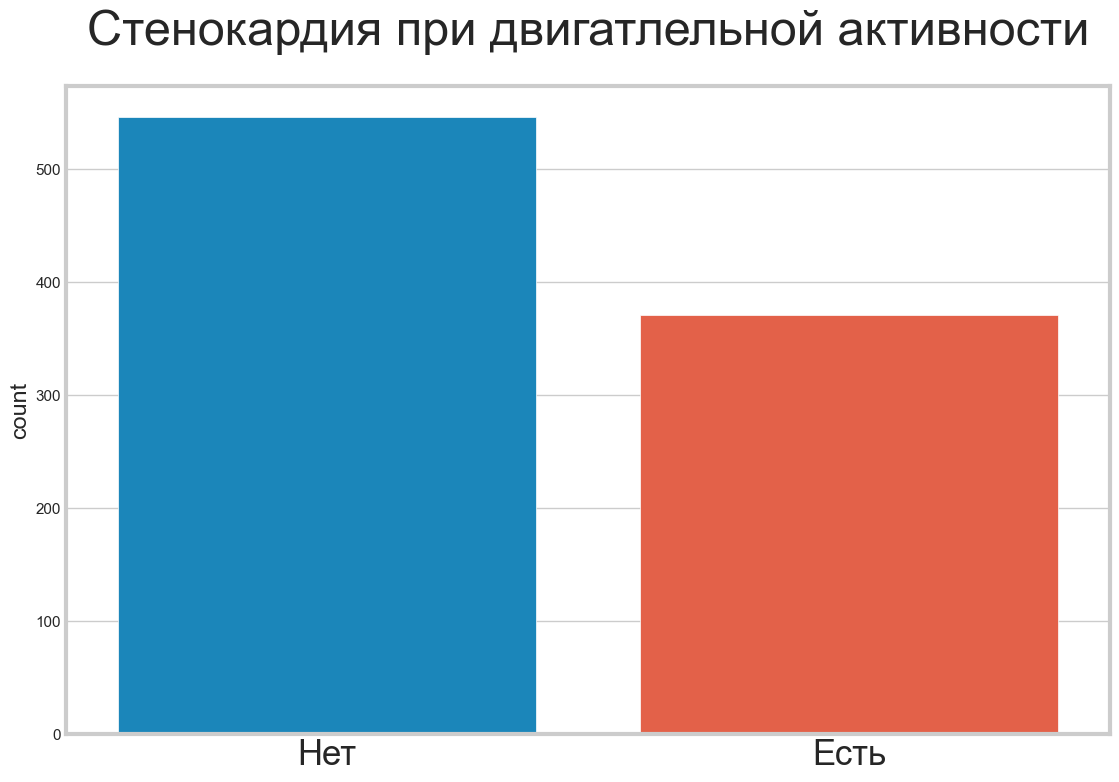

In [38]:
plt.figure(figsize=(12, 8))
exercise_angina_plot = sns.countplot(x=data.ExerciseAngina)
exercise_angina_plot.set_title('Стенокардия при двигатлельной активности', fontsize=35, y=1.05)
exercise_angina_plot.set(xlabel=None)
exercise_angina_plot.set_xticklabels(['Нет', 'Есть'], size=25)

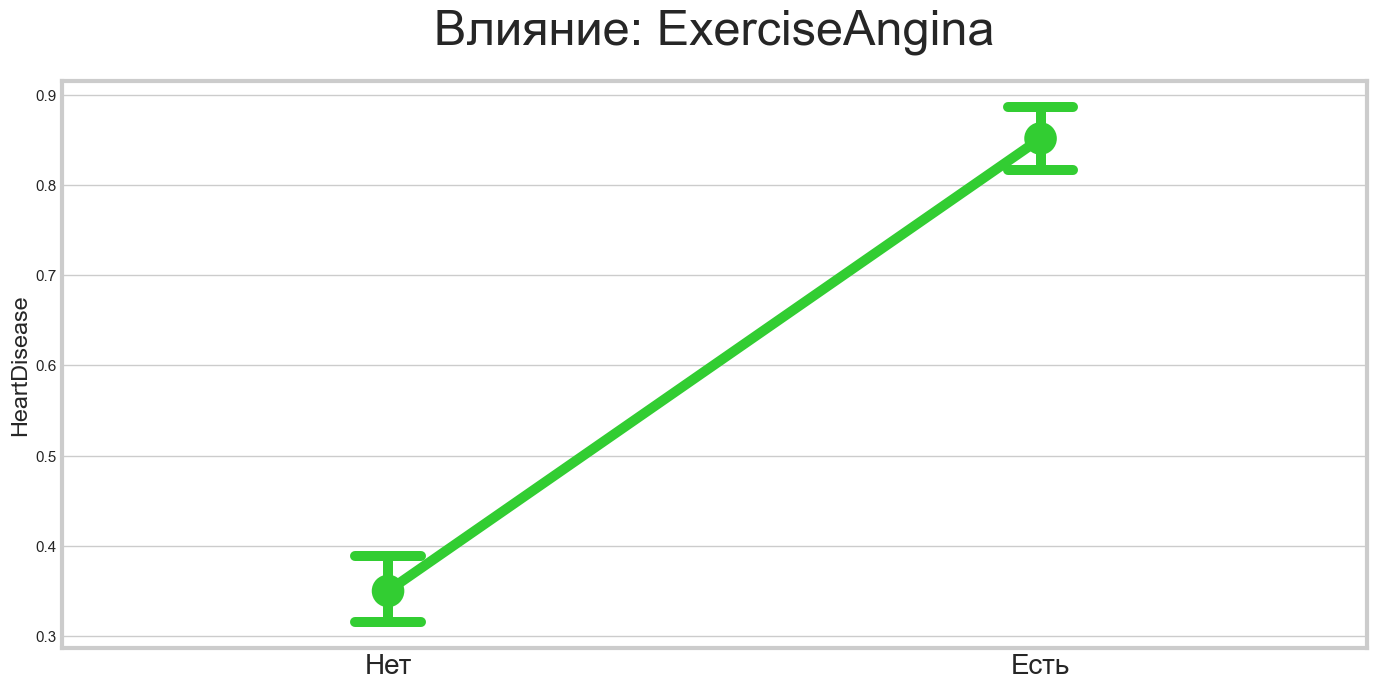

In [41]:
def angina_plot(data, col_name):

    angina_data = data[[col_name, 'HeartDisease']]

    color = np.random.choice(colors, 1)[0]
    plt.figure(figsize=(15, 7))
    angina = sns.pointplot(x=col_name, y='HeartDisease',
                           dodge=0.1, capsize=.1,
                           data=angina_data,
                           color=color)
    angina.set_title(f'Влияние: {col_name}',
                            fontsize=35, y=1.05)
    angina.set(xlabel=None)
    angina.set_xticklabels(['Нет', 'Есть'], size=20)


angina_plot(data, 'ExerciseAngina')

### По графику видно, что отсутствие стенокардии при двигательной активности оказывает влияние на предрасположенность к сердечно-сосудистым заболеваниям

### Oldpeak
Это депрессия ST, вызванная упражнениями относительно отдыха.

Skewness of Oldpeak =======>>> 1.025


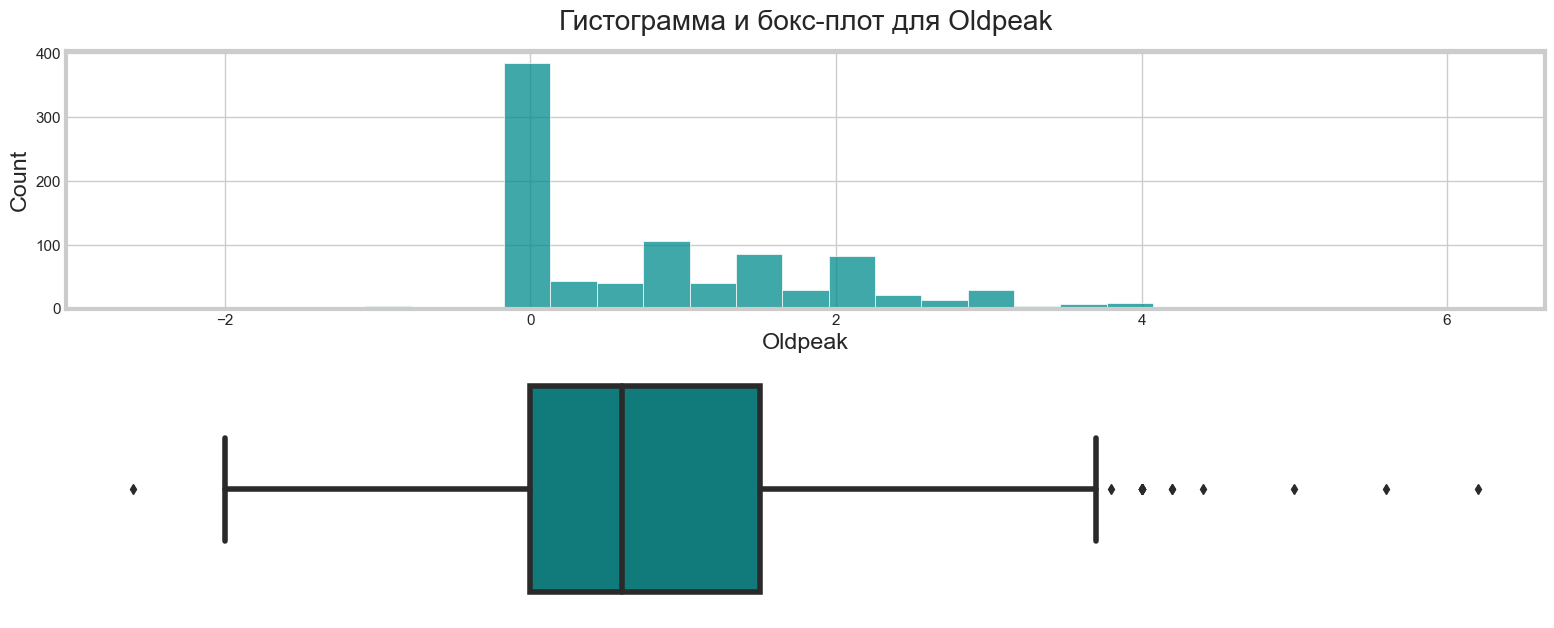

In [42]:
distribution_plot(data.Oldpeak, 'Oldpeak')

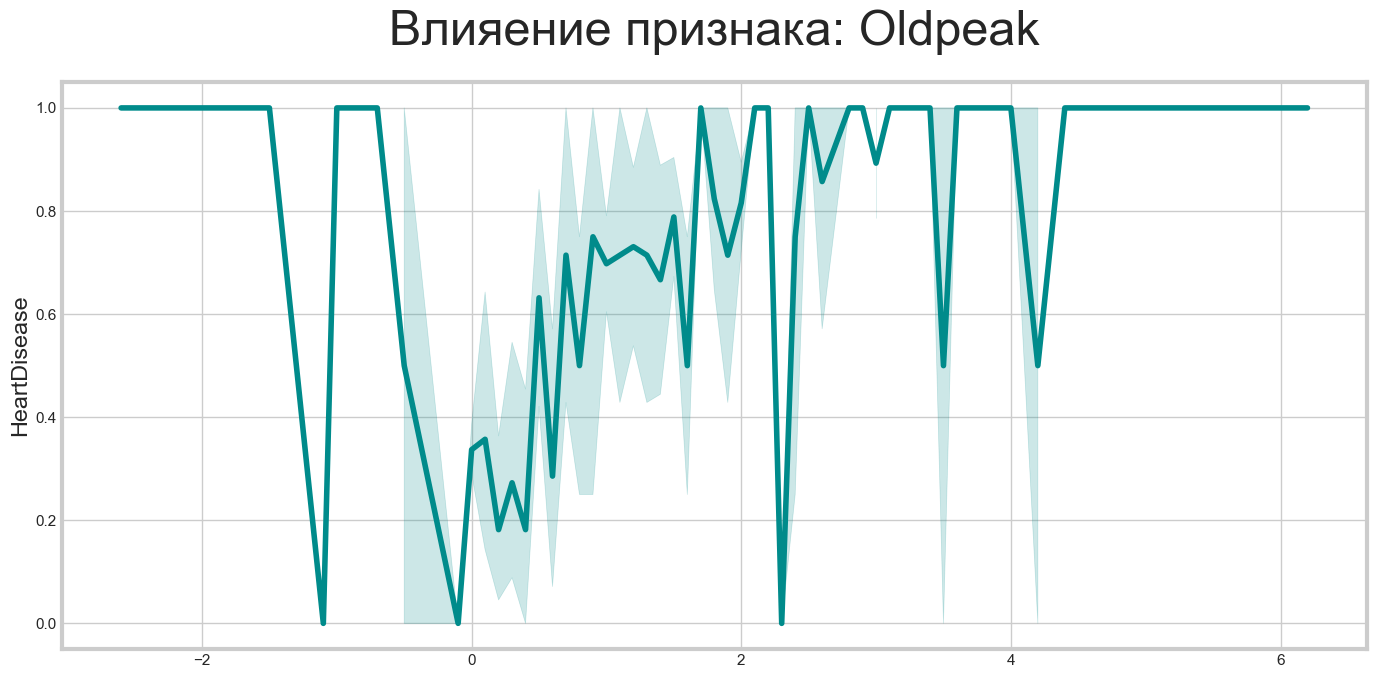

In [43]:
def oldpeak_plot(data, col_name):

    oldpeak_data = data[[col_name, 'HeartDisease']]

    color = np.random.choice(colors, 1)[0]
    plt.figure(figsize=(15, 7))
    oldpeak = sns.lineplot(x=col_name, y='HeartDisease',
                           data=oldpeak_data,
                           color=color)
    oldpeak.set_title(f'Влияение признака: {col_name}',
                            fontsize=35, y=1.05)
    oldpeak.set(xlabel=None)


oldpeak_plot(data, 'Oldpeak')

### Уклон пикового упражнения ST сегмент
- Up   -> Возрастающая линия
- Flat -> Нет наклона (горизонтальное положение)
- Down -> Нисподающая линия

[None, None, None, None, None, None]

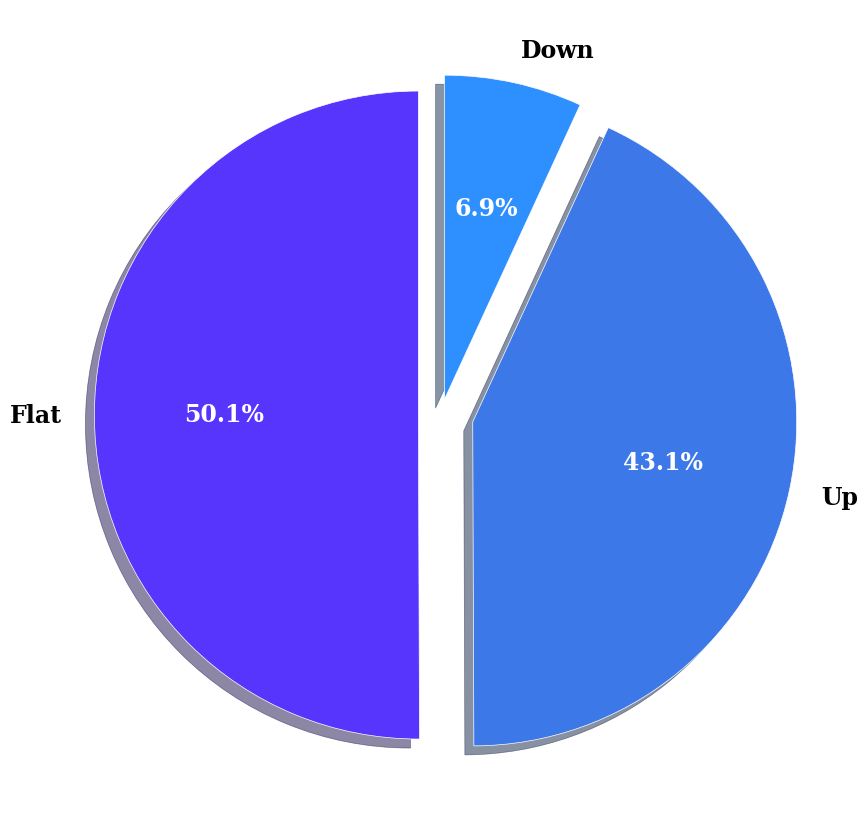

In [44]:
st_slope_data = data.ST_Slope.value_counts()

explode = (0.07, 0.1, 0.05)
pie_colors = ('#5735FD', '#3C78E8', '#2E90FF')

plt.figure(figsize=(15, 10))
patches, texts, pcts = plt.pie(st_slope_data,
        labels=st_slope_data.index,
        explode=explode,
        colors=pie_colors,
        shadow=True,
        startangle=90,
        autopct='%1.1f%%',
        textprops={'fontsize': 17,
                   'color': 'black',
                   'weight': 'bold',
                   'family': 'serif'})
plt.setp(pcts, color='white')

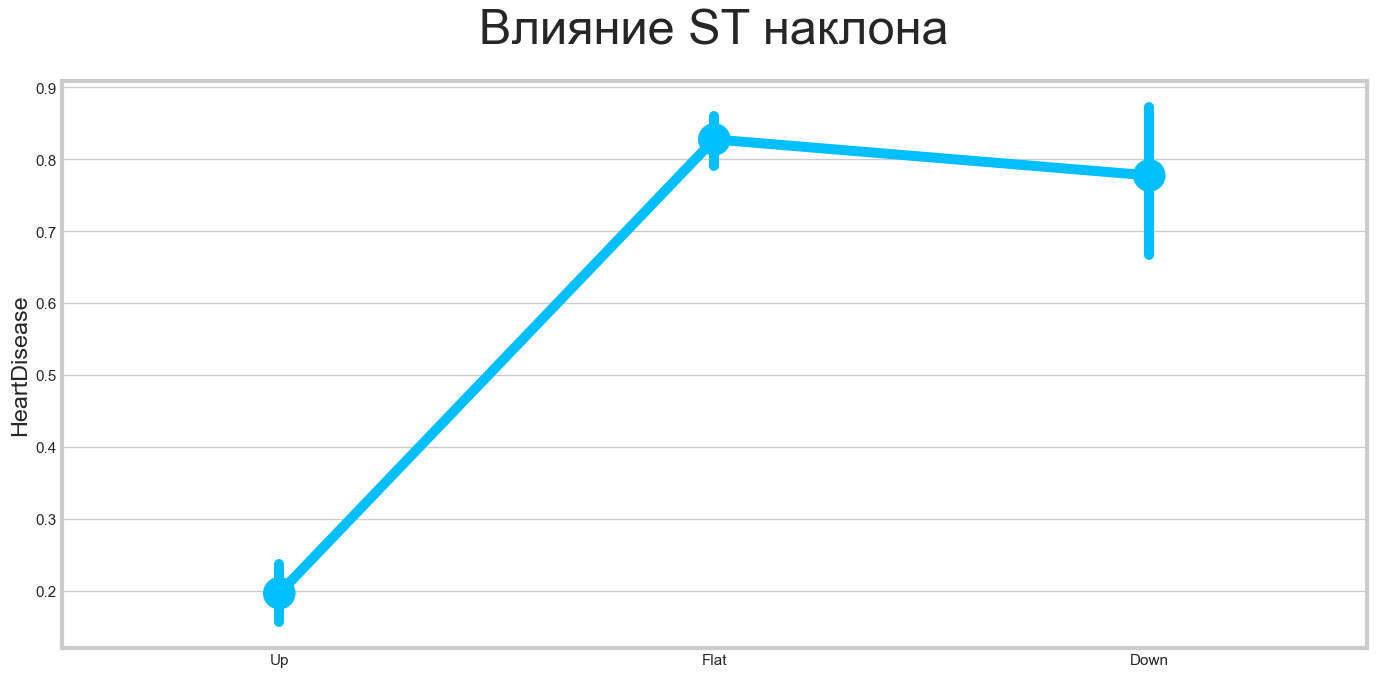

In [46]:

def st_slope_plot(data, col_name):

    st_slope_data = data[[col_name, 'HeartDisease']]

    color = np.random.choice(colors, 1)[0]
    plt.figure(figsize=(15, 7))
    st_slope = sns.pointplot(x=col_name, y='HeartDisease',
                           data=st_slope_data,
                           color=color)
    st_slope.set_title('Влияние ST наклона',
                            fontsize=35, y=1.05)
    st_slope.set(xlabel=None)


st_slope_plot(data, 'ST_Slope')

### Выводы о признаке: лишь при восходящем положение влияние на таргет минимальное

### Coding categorical data

In [ ]:
cat_columns = [cname for cname in data.columns
                        if data[cname].dtype == 'object']

encoder = preprocessing.LabelEncoder()

for col in cat_columns:
    data[col] = encoder.fit_transform(data[col])

## Heatmap

<AxesSubplot:>

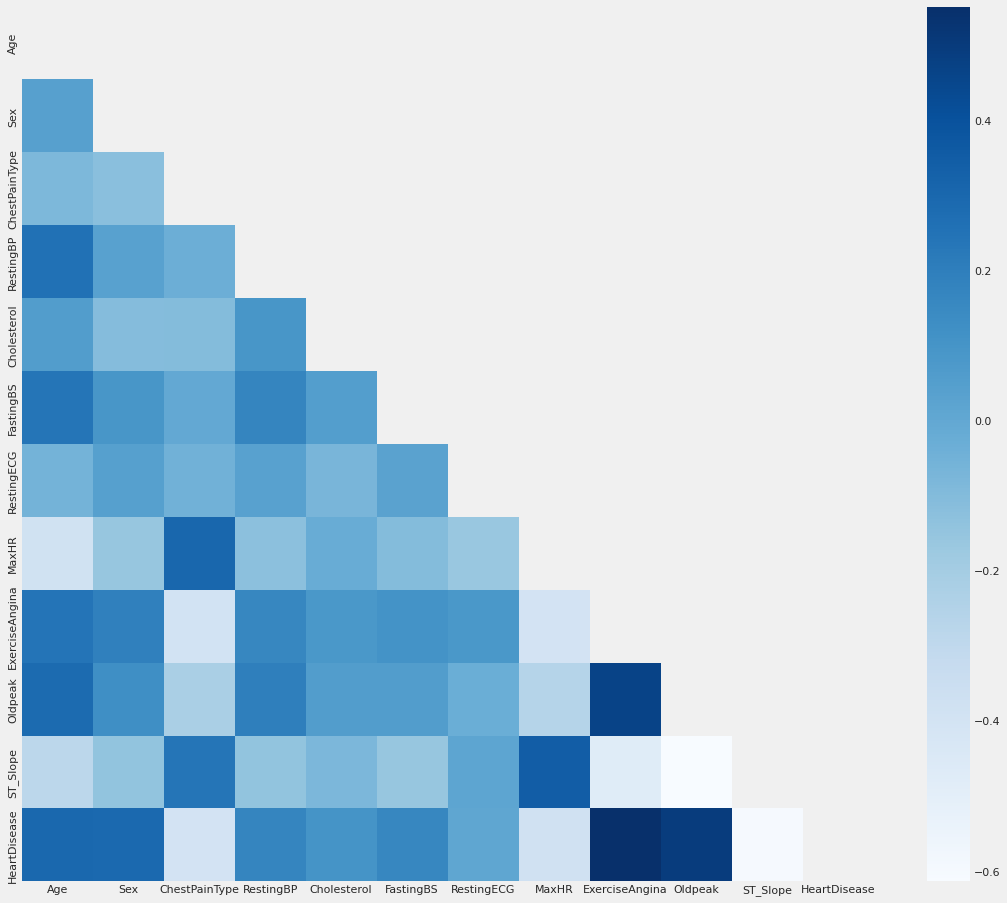

In [ ]:
plt.figure(figsize=(17, 15))

corr_mask = np.triu(data.corr())
h_map = sns.heatmap(data.corr(), mask=corr_mask, cmap='Blues')
h_map

### Conclusions from the heat map:
The highest correlation coefficients with predicted values have ExerciseAngina and Oldpeak

# Data for Model
<img height="100" src="https://github.com/GeorgeGalaxy/PhotosFor.../blob/main/icons/prepare.png?raw=true" width="100"/>

### ~~Work with categorical columns~~

### This paragraph was made in the previous step to take a closer look at the heatmap

### Now, let’s look at a few first lines that we got after coding

In [ ]:
data.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0


### Divide by X and y

In [ ]:
X = data.drop(['HeartDisease'], axis=1)
y = data.HeartDisease

# Model
<img height="100" src="https://github.com/GeorgeGalaxy/PhotosFor.../blob/main/icons/external-training-lineal-.png?raw=true" width="100"/>

## Such models will be uncovered:
1. ### ML (Machine learning) models
    1. Random Forest Classifier
    2. kNN (K-Nearest Neighbours)
    3. GradientBoostingClassifier
2. ### Artificial Neural network

# Machine Learning models

<img height="100" src="https://github.com/GeorgeGalaxy/PhotosFor.../blob/main/icons/ml%20models.png?raw=true" width="100"/>

In [ ]:
models_results = np.zeros(4)

def show_training_results(X, y, model_name, model, split_share=0.3, **kwargs):

    print(f'The model {model_name} with parameters : {kwargs}')
    m = model(**kwargs)

    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=split_share, random_state=rnd_state)

    m.fit(X_train, y_train)

    score = m.score(X_test, y_test)

    print(f'{model_name} score    ========>>> {score:.{3}f}\n')

    plot_conf_mat(m, X_test, y_test)

    return score


def plot_conf_mat(model, X_test, y_test):

    y_pred = model.predict(X_test)
    matrix = confusion_matrix(y_pred, y_test)

    df_cm = pd.DataFrame(matrix, index = ['heart disease', 'Normal'],
                                columns = ['heart disease', 'Normal'])
    plt.figure(figsize = (12,8))
    sns.heatmap(df_cm,
                annot=True,
                cmap='Blues',
                fmt='.5g',
                annot_kws={"size": 20}).set_title('Confusion matrix', fontsize = 25, y=1.05)
    plt.xlabel('Predicted values', fontsize = 20)
    plt.ylabel('True values', fontsize = 20)
    plt.show()

# Random Forest
<img height="100" src="https://github.com/GeorgeGalaxy/PhotosFor.../blob/main/icons/forest.png?raw=true" width="100"/>

The model RF with parameters : {'n_estimators': 500, 'n_jobs': -1, 'random_state': 0}
RF score    ========>>> 0.866



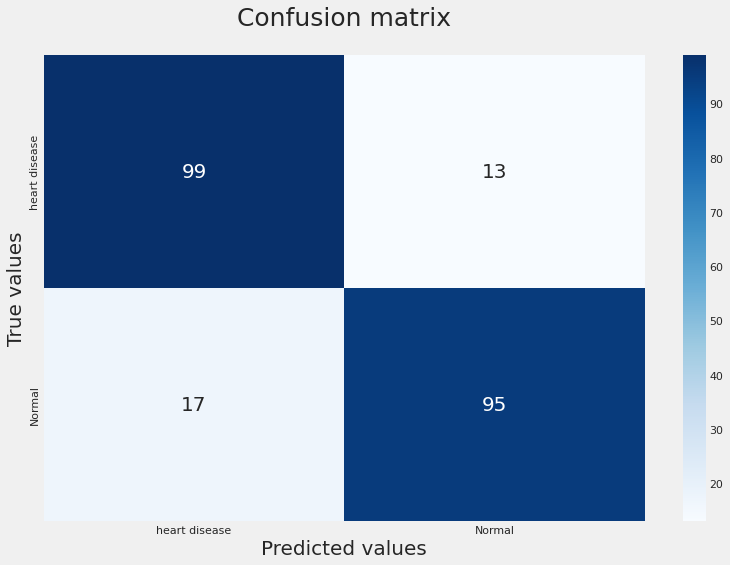

In [ ]:
rnd_state = 0

models_results[0] =   show_training_results(X, y,
                      'RF',
                      RandomForestClassifier,
                      n_estimators=500,
                      n_jobs=-1,
                      random_state=rnd_state)

# K-Nearest Neighbours
<img height="100" src="https://github.com/GeorgeGalaxy/PhotosFor.../blob/main/icons/near-me.png?raw=true" width="100"/>

The model kNN with parameters : {'n_neighbors': 1, 'algorithm': 'kd_tree', 'weights': 'uniform'}
kNN score    ========>>> 0.612



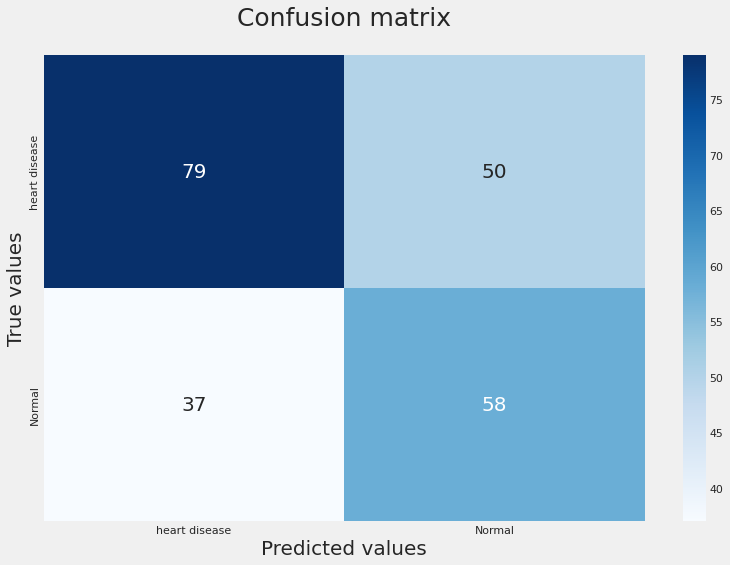

In [ ]:
models_results[1] =   show_training_results(X, y,
                      'kNN',
                      KNeighborsClassifier,
                      n_neighbors=1,
                      algorithm='kd_tree',
                      weights='uniform')

# GradientBoostingClassifier
<img height="100" src="https://github.com/GeorgeGalaxy/PhotosFor.../blob/main/icons/boost-grad.png?raw=true" width="100"/>

The model GradBoost with parameters : {'learning_rate': 0.01, 'loss': 'exponential', 'max_depth': 70, 'max_features': 2, 'n_estimators': 300}
GradBoost score    ========>>> 0.862



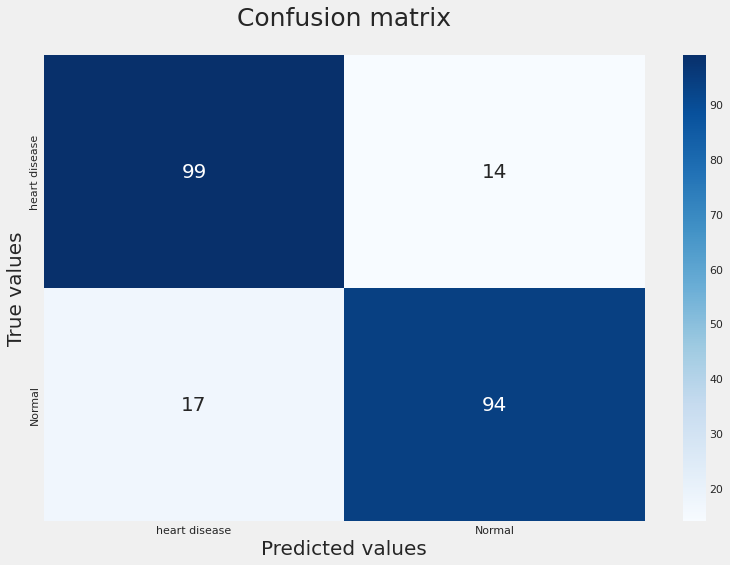

In [ ]:
models_results[2] =   show_training_results(X, y,
                      'GradBoost',
                      GradientBoostingClassifier,
                      learning_rate=0.01,
                      loss='exponential',
                      max_depth=70,
                      max_features=2,
                      n_estimators=300)

# ANN (Artificial Neural Network)
<img height="100" src="https://github.com/GeorgeGalaxy/PhotosFor.../blob/main/icons/neural%20net.png?raw=true" width="100"/>

In [ ]:
os.environ["KMP_SETTINGS"] = "false" # to avoid a huge warning about sort of settings

In [ ]:
def neural_net_results(X, y):

    y = keras.utils.to_categorical(y, 2)

    X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.25,
                                                      random_state=rnd_state)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    model = keras.Sequential([
        keras.layers.Flatten(input_dim=X_train.shape[1]),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train,
              batch_size=10, epochs=70,
              validation_data=(X_val, y_val),
              verbose=0)

    score = np.round(model.evaluate(X_val, y_val, verbose=0)[1], 3)
    print(f'Neural Network score    ========>>> {score}')

    history_plot(history)

    return score


def history_plot(history):

    fig = plt.figure(figsize=(12, 8))
    plt.plot(history.history['accuracy'], label="Train loss")
    plt.plot(history.history['val_accuracy'], label="Test loss")
    plt.legend()


def plot_nn_model(model):
    plot_model(model, show_shapes=True)

2022-02-21 16:31:36.446144: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-02-21 16:31:36.608967: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Neural Network score    ========>>> 0.877


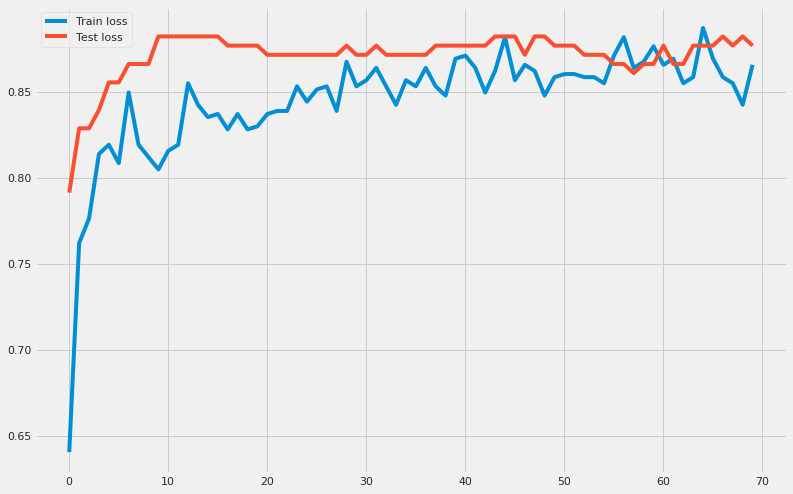

In [ ]:
models_results[-1] = neural_net_results(X, y)

## Neural Network structure
<img height="100" src="https://github.com/GeorgeGalaxy/PhotosFor.../blob/main/icons/structure.png?raw=true" width="100"/>

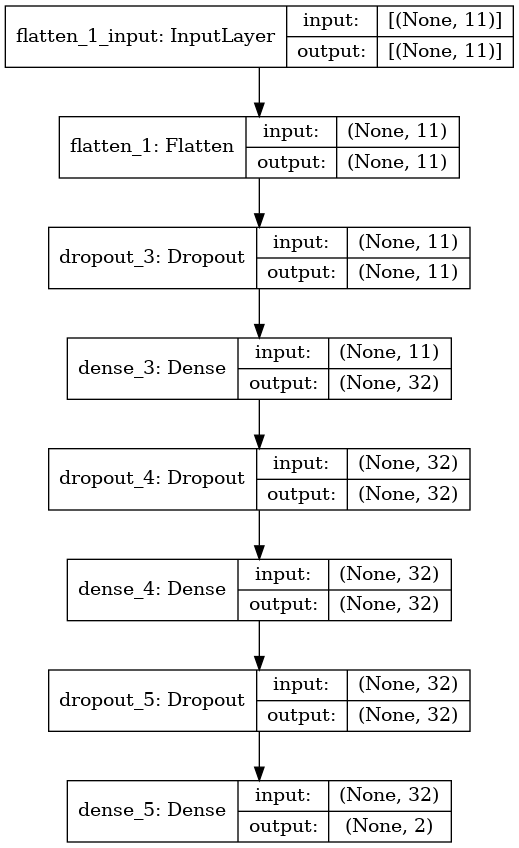

In [ ]:
plot_model(keras.Sequential([
        keras.layers.Flatten(input_dim=X.shape[1]),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(2, activation='softmax')
    ]), show_shapes=True)

# Models Evaluating
<img height="100" src="https://github.com/GeorgeGalaxy/PhotosFor.../blob/main/icons/evaluate.png?raw=true" width="100"/>

### Aggregation of results into one dataset

In [ ]:
models_results = pd.DataFrame(models_results, columns=['Result'])
models_results['Model name'] = \
    ['Random Forest', 'kNN', 'Gradient Boosting', 'ANN']
models_results.sort_values(by=['Result'], inplace=True)

### Accuracy plot for each model type

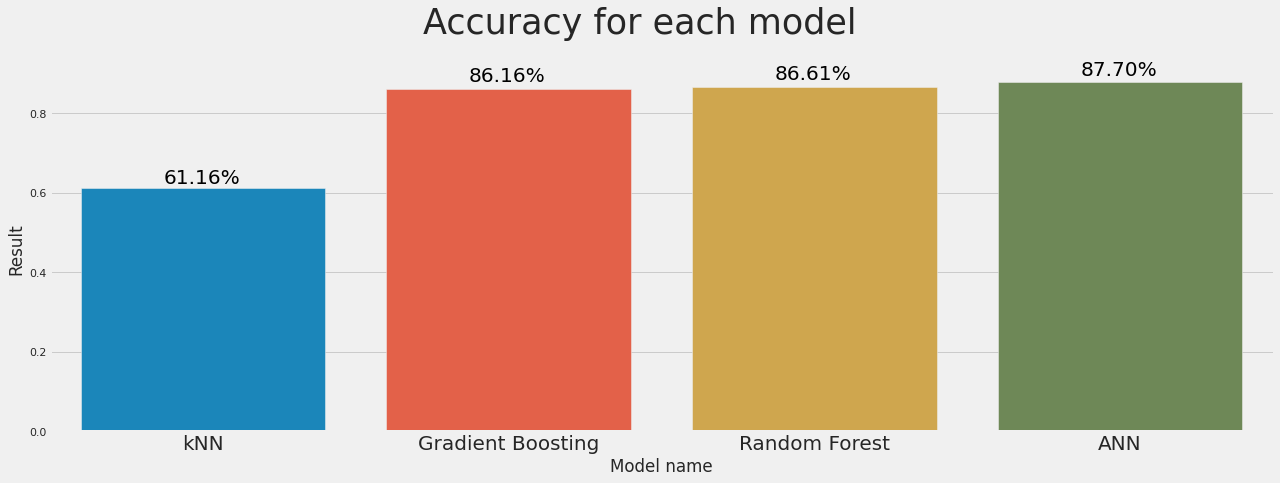

In [ ]:
g = sns.catplot(x='Model name', y='Result', data=models_results,
            height=6, aspect=3, kind='bar', legend=True)
g.fig.suptitle('Accuracy for each model', size=35, y=1.1)
ax = g.facet_axis(0,0)
ax.tick_params(axis='x', which='major', labelsize=20)
for p in ax.patches:
    ax.text(p.get_x() + 0.27,
            p.get_height() * 1.02,
           '{0:.2f}%'.format(p.get_height()*100),
            color='black',
            rotation='horizontal',
            size='x-large')

# <center>Conclusions</center>
<img height="100" src="https://github.com/GeorgeGalaxy/PhotosFor.../blob/main/icons/conclusion.png?raw=true" width="100"/>

---

## Data analysis: 
- In this work, we looked at some tools that can be used for EDA (Exploratory data analysis): categorical plot, count plot, several version of pie plot
- After analysis, we have identified certain circumstances (factors) that have a bearing on the outcome of the examination of patients

## Application of models:
- In the most cases ANN shows the best results in prediction (~87% accuracy)
- At the same time, kNN was the worst performer

## <center>Notebooks that also use machine learning:</center>

### [Stroke prediction](https://www.kaggle.com/galaxygeorge/stroke-prediction-eda-fe-model)
### [Water Quality prediction](https://www.kaggle.com/galaxygeorge/water-quality-prediction-eda-model)
### [Customer Churn](https://www.kaggle.com/galaxygeorge/customer-churn-modeling-eda-fe-model)
### [House price prediction](https://www.kaggle.com/galaxygeorge/house-price-prediction-eda-fe-model)

# <center> Thank You ! </center>

<img height="150" src="https://github.com/GeorgeGalaxy/PhotosFor.../blob/main/icons/thank-you.png?raw=true" width="150"/>

## <center> If you have found something useful for yourself in my work , please evaluate and comment </center>

![](https://github.com/GeorgeGalaxy/PhotosFor.../blob/main/LinePurplePink.jpg?raw=true)